In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pickle
import plotly.graph_objects as go

    1. Число умерших на 1-м году жизни детей за год по всем регионам в сельской и городской местностях

In [2]:
child_mortality = {}
child_mortality['rural'] = pd.read_excel('data/child_mortality_rural_1990_2021.xls', sheet_name='Данные', skiprows=[0, 1])
child_mortality['urban'] = pd.read_excel('data/child_mortality_urban_1990_2021.xls', sheet_name='Данные', skiprows=[0, 1])
for key in child_mortality.keys():
    child_mortality[key].drop(columns=['Unnamed: 1', 'Unnamed: 2'], inplace=True)
    child_mortality[key].rename(columns={'Unnamed: 0': 'region'}, inplace=True)

In [3]:
def change_region(x):
    #предварительный анализ файлов показал:
    # 1. до 2002 года было деление на такие крупные субъекты как районы (Центральный, Уральский, Дальневосточный), 
    # в то же время присутствуют по этим регионам данные с разбиением, поэтому можно их отбросить
    # в файле они не имеют отступа
    # 2. федеральные округа тоже слишком крупные субъекты, они имеют отступ в 4 пробела, их мы тоже удаляем
    # также присутствуют слишком мелкие субьекты, входящие в состав более крупного,
    # по которым, как правило, данные есть не за все года
    # в файле у них отступ 12 пробелов - их тоже откидываем 
    x = str(x)
    count = 0
    for i in range(len(x)):
        if x[i] != ' ': 
            if i ==0:
                return False
            else:
                if count == 4:
                    return False
                elif count == 12:
                    return False
                else:
                    return True
        else:
            count += 1
            
def change_city(x):
    #необходимо подкорректировать названия для крупных городов (сейчас они слишком длинные и не совпадают с другими таблицами)
    x = str(x)
    x = x[0].upper() + x[1:]
    x = x.replace('  ', ' ')
    if 'Севастополь' in x:
        x = 'Севастополь'
    if 'Москва' in x:
        x = 'Москва'
    if 'Санкт-Петербург' in x or 'Санкт - Петербург' in x:
        x = 'Санкт-Петербург'
    if '(' in x:
        temp = x.split('(')
        x = temp[0]
    if 'Осетия - Алания' in x:
        x = x.replace(' - ', '-')
    if x.find(' - ') != -1:
        temp = x.split(' - ')
        x = temp[0]
    if 'авт. область' in x:
        x = x.replace('авт. область', 'автономная область')
    if 'авт. округ' in x:
        x = x.replace('авт. округ', 'автономный округ')
    if ' без автономного округа' in x:
        x = x.replace(' без автономного округа', '')
    return x.strip()

In [4]:
for key in child_mortality.keys():
    mask = child_mortality[key]['region'].apply(change_region)
    child_mortality[key] = child_mortality[key][mask]
    child_mortality[key]['region'] = child_mortality[key]['region'].apply(change_city)

In [5]:
child_mortality['rural'].describe()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,77.000000,77.000000,77.000000,...,79.000000,80.000000,80.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,139.825000,136.787500,126.387500,123.000000,112.625000,107.275000,99.787500,100.012987,93.688312,91.870130,...,69.151899,63.237500,57.675000,50.792683,43.512195,36.975610,30.743902,25.878049,23.365854,22.585366
std,121.559984,125.594656,115.064153,110.006674,103.769386,96.913504,93.077577,90.027846,87.651262,87.792421,...,81.904273,66.163825,67.234857,60.710553,48.626631,44.388013,36.009879,30.316190,27.606813,27.499473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.750000,58.000000,54.750000,59.250000,50.750000,51.000000,47.000000,48.000000,44.000000,43.000000,...,28.500000,26.750000,22.000000,21.250000,17.250000,14.000000,10.000000,9.000000,8.000000,8.250000
50%,111.500000,103.500000,86.500000,93.500000,84.000000,81.500000,72.500000,70.000000,68.000000,65.000000,...,47.000000,41.500000,35.000000,33.500000,30.500000,21.500000,20.000000,16.000000,13.500000,13.000000
75%,189.000000,178.250000,159.250000,165.500000,147.250000,132.500000,130.750000,120.000000,110.000000,113.000000,...,70.500000,81.500000,70.250000,56.000000,53.500000,42.500000,36.000000,32.750000,31.000000,25.750000
max,662.000000,684.000000,645.000000,646.000000,599.000000,561.000000,589.000000,593.000000,604.000000,616.000000,...,539.000000,449.000000,461.000000,438.000000,342.000000,295.000000,243.000000,207.000000,181.000000,176.000000


In [6]:
#посмотрим пропущенные значения
is_null = child_mortality['urban'].isnull()
row_null = is_null.any(axis=1)
child_mortality['urban'][row_null]

,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
38,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,62.0,58.0,49.0,37.0,36.0,48.0,46.0
43,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.0,24.0,19.0,12.0,15.0,15.0,21.0
50,Чеченская Республика,263.0,326.0,393.0,0.0,0.0,0.0,0.0,NaN,NaN,...,322.0,301.0,174.0,141.0,114.0,102.0,72.0,68.0,109.0,116.0


In [7]:
is_null = child_mortality['rural'].isnull()
row_null = is_null.any(axis=1)
child_mortality['rural'][row_null]

,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
19,Москва,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,3.0,9.0,11.0,6.0,11.0,13.0,14.0,5.0,10.0,9.0
32,Санкт-Петербург,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,88.0,63.0,63.0,43.0,53.0,54.0,51.0
43,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,2.0,1.0,1.0,0.0,0.0,0.0
50,Чеченская Республика,662.0,660.0,510.0,0.0,0.0,0.0,0.0,NaN,NaN,...,439.0,269.0,319.0,244.0,190.0,171.0,137.0,99.0,72.0,81.0


    По 5 субъектам есть пропущенные значения: Крым и Севастополь - данные только с 2015 года. По Севастополю, Санкт-Петербургу и Москве маленькие значения (либо нулевые) по сельскому населению. 
    Думаю, имеет смысл просуммировать данные по городу и сельской местности, чтобы иметь показатель по смертности по региону в целом.
    Для задачи определения регионов России наиболее нуждающихся в помощи считаю, что имеет смысл рассматривать данные, начиная с 2017 года, т.е. за 5 лет (файлы с экономическими показателями в основном охватывают именно период, начиная с 2015 или 2017 гг).

In [8]:
for key in child_mortality.keys():
    for column in child_mortality[key].columns:
        #удаляем все столбцы ранее 2017
        if column == 'region': continue
        if int(column) < 2017:
            child_mortality[key].drop(columns=column, inplace=True)
        
    is_null = child_mortality[key].isnull()
    row_null = is_null.any(axis=1)
    print(child_mortality[key][row_null])#проверяем не остались ли нулевые значения

Empty DataFrame
Columns: [region, 2017, 2018, 2019, 2020, 2021]
Index: []
Empty DataFrame
Columns: [region, 2017, 2018, 2019, 2020, 2021]
Index: []


In [9]:
#выделим список полученных регионов для отбора в других файлах
regions = sorted(child_mortality['rural']['region'].unique().tolist())
print(f'Получилось количество субьектов - {len(regions)}')

Получилось количество субьектов - 82


In [10]:
for key in child_mortality.keys():
    child_mortality[key].sort_values(by='region', inplace=True)
    child_mortality[key].index = regions
    child_mortality[key].drop(columns='region', inplace=True)

In [11]:
#обобщим данные из двух таблиц
child_mortality_all = pd.DataFrame(index=regions, columns=['2017', '2018', '2019', '2020', '2021'])
for column in child_mortality_all.columns:
    child_mortality_all[column] = child_mortality['rural'][column] + child_mortality['urban'][column]
child_mortality_all

,2017,2018,2019,2020,2021
Алтайский край,185.0,176.0,114.0,97.0,88.0
Амурская область,48.0,46.0,43.0,42.0,36.0
Архангельская область,76.0,54.0,59.0,33.0,35.0
Астраханская область,74.0,71.0,72.0,64.0,46.0
Белгородская область,77.0,73.0,39.0,47.0,54.0
...,...,...,...,...,...
Челябинская область,257.0,215.0,171.0,133.0,144.0
Чеченская Республика,273.0,209.0,167.0,181.0,197.0
Чувашская Республика,47.0,58.0,36.0,24.0,29.0
Чукотский автономный округ,7.0,8.0,6.0,8.0,8.0


In [12]:
temp_df = child_mortality_all.copy()
temp_df.sort_values(by='2021', ascending=False, inplace=True)
legend = temp_df.index
temp_df

,2017,2018,2019,2020,2021
Москва,776.0,715.0,647.0,450.0,468.0
Республика Дагестан,451.0,381.0,357.0,317.0,351.0
Московская область,367.0,341.0,296.0,246.0,278.0
Краснодарский край,298.0,263.0,229.0,230.0,248.0
Ростовская область,288.0,212.0,182.0,200.0,235.0
...,...,...,...,...,...
Сахалинская область,29.0,17.0,25.0,25.0,16.0
Камчатский край,22.0,20.0,29.0,14.0,15.0
Чукотский автономный округ,7.0,8.0,6.0,8.0,8.0
Республика Калмыкия,15.0,19.0,4.0,8.0,7.0


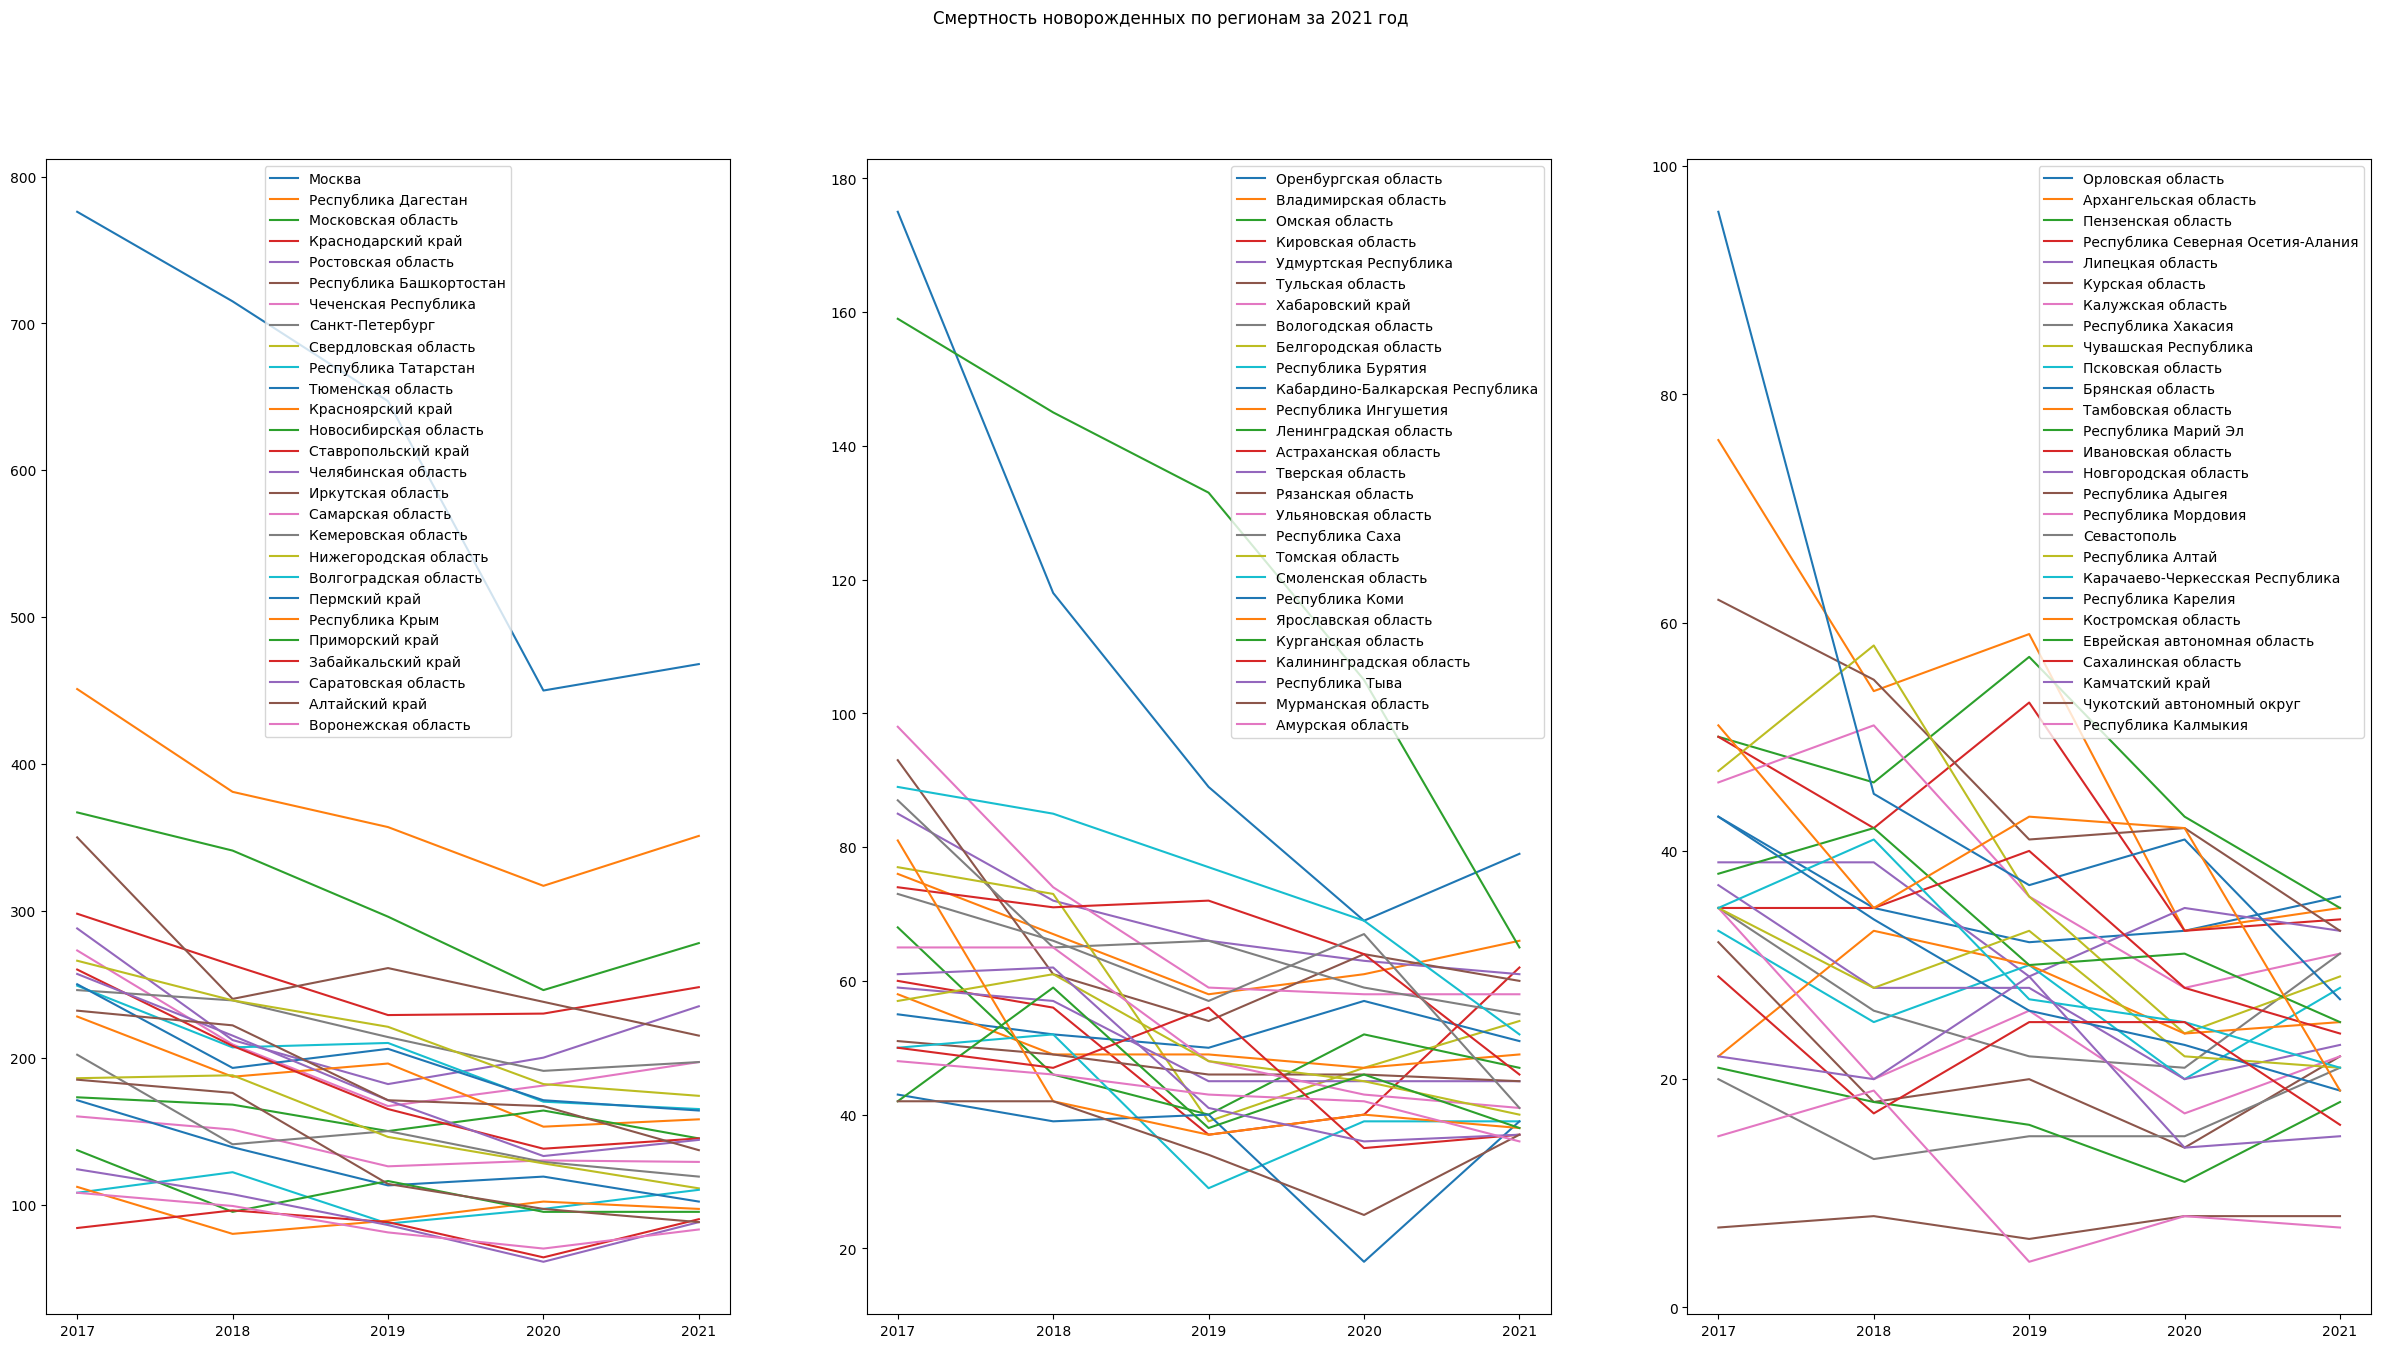

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

plt.suptitle('Смертность новорожденных по регионам за 2021 год')
for i in range(3):
    for k in range(i*27, (i+1)*27): 
        axes[i].plot(temp_df.loc[legend[k], :])
    axes[i].legend(legend[i*27: (i+1)*27])
plt.show()

    2. Рожденные по месяцам по регионам с 2006 - 2022 гг

In [14]:
newborn = pd.read_csv('data/newborn_2006_2022_monthly.csv', sep=';')
newborn.rename(columns={'Region': 'region'}, inplace=True)
newborn.head()

,region,январь 2006 г.,февраль 2006 г.,март 2006 г.,апрель 2006 г.,май 2006 г.,июнь 2006 г.,июль 2006 г.,август 2006 г.,сентябрь 2006 г.,...,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.,Unnamed: 198
0,Российская Федерация,109422,"114068,99","129177,99","113391,99","125099,99",124238,"125926,99","140227,99","123949,99",...,"121645,99","120080,99","114976,99","117945,99",103782,101082,115512,"99696,99",103159,NaN
1,Центральный федеральный округ,"24998,99","25539,99","29558,99",25781,29137,28837,"28997,99","31590,99","27755,99",...,29727,"29532,99",29093,29477,25827,25678,28086,"24979,99",26304,NaN
2,Белгородская область,1040,1094,1190,1044,1228,1249,1224,1389,1157,...,1084,1053,990,1028,861,941,956,801,869,NaN
3,Брянская область,904,989,1039,936,1072,961,1058,1121,989,...,784,751,783,729,707,670,740,589,660,NaN
4,Владимирская область,1040,1059,1236,1063,1226,1144,1221,1333,1177,...,783,834,769,821,691,700,708,660,711,NaN


In [15]:
newborn['region'] = newborn['region'].apply(change_city)
newborn = newborn[newborn['region'].isin(regions)]
newborn.drop(columns='Unnamed: 198', inplace=True)
newborn.head()

,region,январь 2006 г.,февраль 2006 г.,март 2006 г.,апрель 2006 г.,май 2006 г.,июнь 2006 г.,июль 2006 г.,август 2006 г.,сентябрь 2006 г.,...,август 2021 г.,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.
2,Белгородская область,1040,1094,1190,1044,1228,1249,1224,1389,1157,...,1154,1084,1053,990,1028,861,941,956,801,869
3,Брянская область,904,989,1039,936,1072,961,1058,1121,989,...,835,784,751,783,729,707,670,740,589,660
4,Владимирская область,1040,1059,1236,1063,1226,1144,1221,1333,1177,...,864,783,834,769,821,691,700,708,660,711
5,Воронежская область,1301,1479,1689,1513,1729,1555,1620,1897,1554,...,1708,1643,1278,1758,1584,1342,1326,1576,1309,1319
6,Ивановская область,714,799,829,806,840,847,859,865,812,...,630,620,598,609,614,562,506,628,536,562


In [16]:
newborn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 2 to 108
Columns: 198 entries, region to май 2022 г.
dtypes: object(198)
memory usage: 132.1+ KB


In [17]:
dubl = newborn[newborn.duplicated(subset='region')]['region'].to_list()
newborn[newborn['region'].isin(dubl)]

,region,январь 2006 г.,февраль 2006 г.,март 2006 г.,апрель 2006 г.,май 2006 г.,июнь 2006 г.,июль 2006 г.,август 2006 г.,сентябрь 2006 г.,...,август 2021 г.,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.
19,Москва,6728,"6945,99","8269,99","7356,99",7999,8208,8087,8864,7714,...,11824,"11096,99",11479,10825,11014,9623,"9593,99",10171,9489,9973
23,Архангельская область,1136,1045,1260,1133,1201,1147,1334,1297,1106,...,782,736,741,700,754,654,630,764,656,687
25,Архангельская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,729,681,702,659,707,614,579,709,629,649
71,Тюменская область,"2992,99",3585,"3714,99",3630,3855,3817,3638,"3733,99",4044,...,3802,3914,3881,"3744,99",3976,3431,3203,3888,3394,3589
74,Тюменская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1589,1635,1622,1544,1599,1479,1294,1551,1329,1410
108,Москва,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
newborn.drop_duplicates(subset='region', inplace=True)
#посмотрим сколько пропусков
newborn.isnull().sum().sum()

216

Нам необходимо определить статистику именно по годам, чтобы можно было сталкивать эти данные с данными из других файлов, но для начала нужно посмотреть на пропуски. Посмотрим по каким регионам и годам они есть

In [19]:
empty_period =[]
empty_region =[] 
for column in newborn.drop(columns='region').columns:
    #print(newborn[column].isnull())
    if newborn[column].isnull().sum():
        empty_period.append(column)
    regs = newborn[newborn[column].isnull()]['region'].to_list()
    for item in regs:
        if item not in empty_region:
            empty_region.append(item)
print(empty_period)
print(empty_region)

['январь 2006 г.', 'февраль 2006 г.', 'март 2006 г.', 'апрель 2006 г.', 'май 2006 г.', 'июнь 2006 г.', 'июль 2006 г.', 'август 2006 г.', 'сентябрь 2006 г.', 'октябрь 2006 г.', 'ноябрь 2006 г.', 'декабрь 2006 г.', 'январь 2007 г.', 'февраль 2007 г.', 'март 2007 г.', 'апрель 2007 г.', 'май 2007 г.', 'июнь 2007 г.', 'июль 2007 г.', 'август 2007 г.', 'сентябрь 2007 г.', 'октябрь 2007 г.', 'ноябрь 2007 г.', 'декабрь 2007 г.', 'январь 2008 г.', 'февраль 2008 г.', 'март 2008 г.', 'апрель 2008 г.', 'май 2008 г.', 'июнь 2008 г.', 'июль 2008 г.', 'август 2008 г.', 'сентябрь 2008 г.', 'октябрь 2008 г.', 'ноябрь 2008 г.', 'декабрь 2008 г.', 'январь 2009 г.', 'февраль 2009 г.', 'март 2009 г.', 'апрель 2009 г.', 'май 2009 г.', 'июнь 2009 г.', 'июль 2009 г.', 'август 2009 г.', 'сентябрь 2009 г.', 'октябрь 2009 г.', 'ноябрь 2009 г.', 'декабрь 2009 г.', 'январь 2010 г.', 'февраль 2010 г.', 'март 2010 г.', 'апрель 2010 г.', 'май 2010 г.', 'июнь 2010 г.', 'июль 2010 г.', 'август 2010 г.', 'сентябрь 2010 

Т.е. пропущенные данные только по Крыму до 2015 года. Значит, отбрасываем данные до 2017 года, а также за 2022 год - т.к. там идет статистика только по май включительно

In [20]:
newborn_columns = newborn.drop(columns='region').columns.to_list()
years = list(range(2006, 2017))
years.append(2022)
years
for year in years:
    for column in newborn_columns:
        if str(year) in column:
            newborn.drop(columns=column, inplace=True)
newborn.head()

,region,январь 2017 г.,февраль 2017 г.,март 2017 г.,апрель 2017 г.,май 2017 г.,июнь 2017 г.,июль 2017 г.,август 2017 г.,сентябрь 2017 г.,...,март 2021 г.,апрель 2021 г.,май 2021 г.,июнь 2021 г.,июль 2021 г.,август 2021 г.,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.
2,Белгородская область,1243,1118,1339,1035,1226,1314,1322,1518,1239,...,1068,903,882,1133,1113,1154,1084,1053,990,1028
3,Брянская область,939,973,947,797,1016,992,1064,1117,876,...,834,672,692,775,852,835,784,751,783,729
4,Владимирская область,1135,1006,1169,1000,1083,1202,1198,1272,1087,...,854,787,789,859,927,864,783,834,769,821
5,Воронежская область,1768,1698,1905,1599,1834,1901,1976,2272,1855,...,1817,1436,1300,1818,1635,1708,1643,1278,1758,1584
6,Ивановская область,771,735,908,744,797,844,890,901,811,...,648,586,557,692,670,630,620,598,609,614


In [21]:
newborn_columns = newborn.drop(columns='region').columns.to_list()
for year in range(2017, 2022):
    tmp = np.zeros(newborn.shape[0])
    for column in newborn_columns:
        if str(year) in column:
            newborn[column] = newborn[column].apply(lambda x: int(str(x).replace(',', '.').split('.')[0]))
            tmp += newborn[column]
            newborn.drop(columns=column, inplace=True)
    newborn[str(year)] = tmp
newborn.head()

,region,2017,2018,2019,2020,2021
2,Белгородская область,15113.0,14318.0,13197.0,12351.0,12223.0
3,Брянская область,11552.0,11124.0,10028.0,9480.0,9047.0
4,Владимирская область,13395.0,12658.0,11158.0,10120.0,9780.0
5,Воронежская область,22423.0,21381.0,19643.0,19161.0,18593.0
6,Ивановская область,9877.0,9134.0,7951.0,7563.0,7327.0


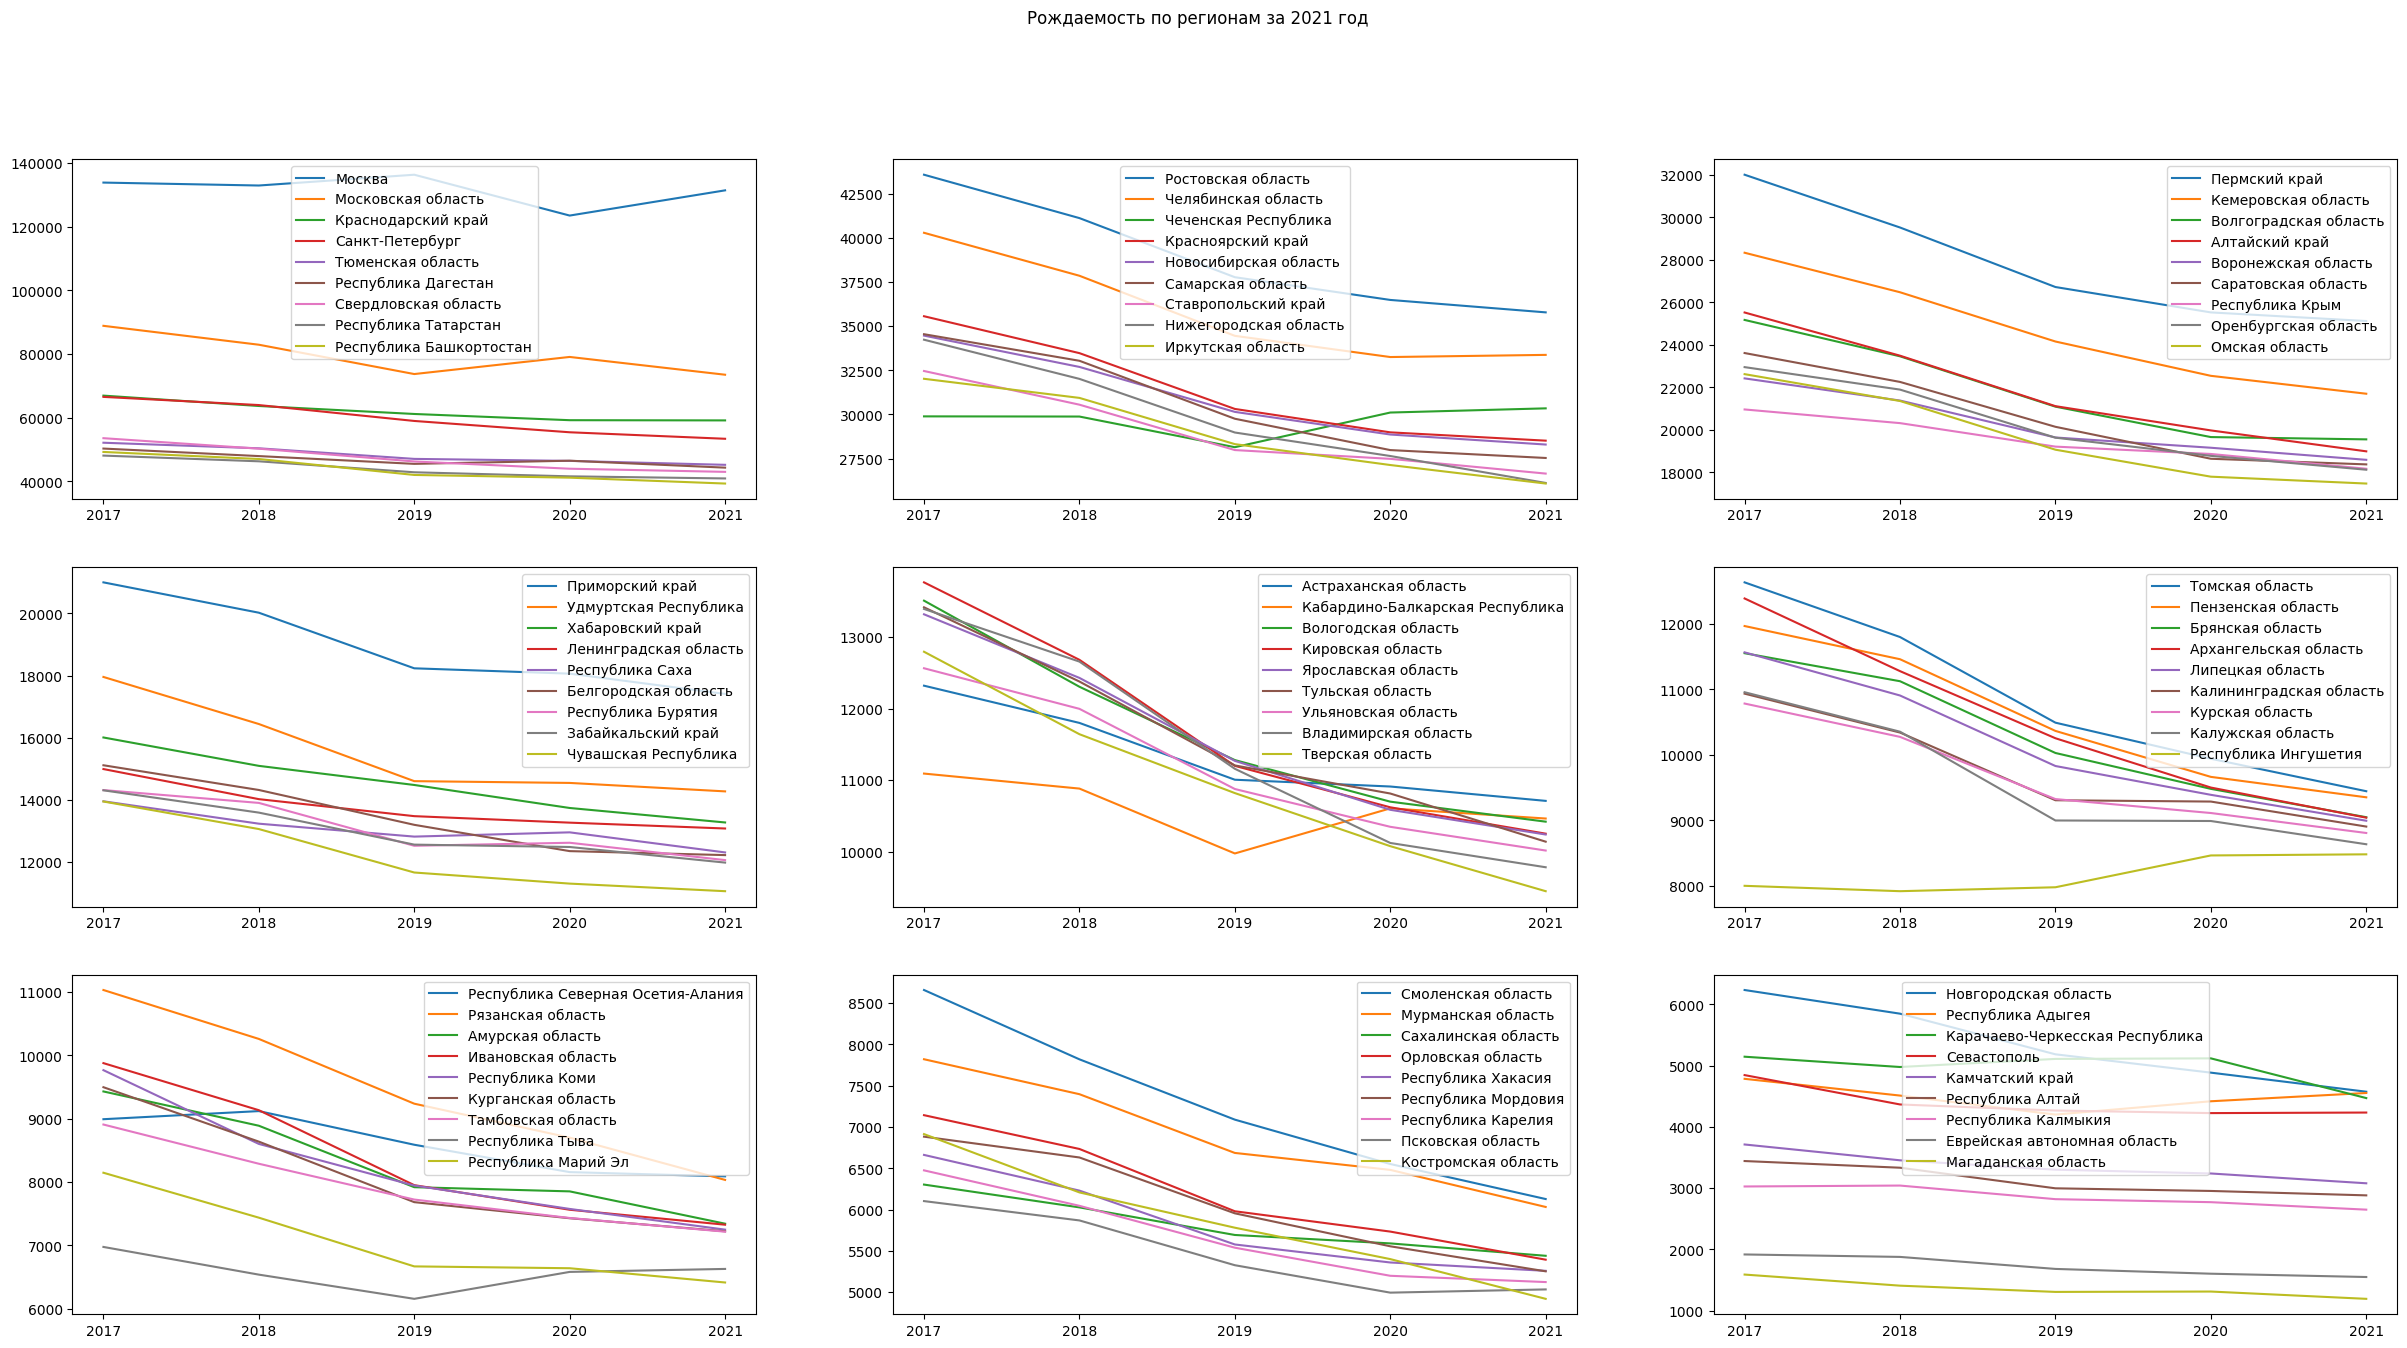

In [22]:
temp_df = newborn.copy()
temp_df.sort_values(by='2021', ascending=False, inplace=True)
temp_df.index = temp_df['region']
temp_df.drop(columns='region', inplace=True)
temp_region = temp_df.index.to_list()
fig, axes = plt.subplots(3, 3, figsize=(30, 15))

plt.suptitle('Рождаемость по регионам за 2021 год')
for i in range(3):
    for k in range(3): 
        for j in range((i*3+k)*9, ((i*3+k+1)*9)):
            axes[i, k].plot(temp_df.loc[temp_region[j], :])
        axes[i, k].legend(temp_region[(i*3+k)*9: (i*3+k+1)*9])
plt.show()

Наблюдается снижение рождаемости по всем регионам.
Найдем процент умерших детей на 1-м году жизни от количества рожденных по годам

In [23]:
newborn.sort_values(by='region', inplace=True)
newborn.index = newborn['region']
newborn.drop(columns='region', inplace=True)
newborn

,2017,2018,2019,2020,2021
region,,,,,
Алтайский край,25523.0,23491.0,21117.0,19976.0,18992.0
Амурская область,9430.0,8889.0,7919.0,7853.0,7343.0
Архангельская область,12388.0,11278.0,10253.0,9500.0,9040.0
Астраханская область,12321.0,11800.0,11005.0,10910.0,10709.0
Белгородская область,15113.0,14318.0,13197.0,12351.0,12223.0
...,...,...,...,...,...
Челябинская область,40286.0,37853.0,34451.0,33250.0,33372.0
Чеченская Республика,29890.0,29880.0,28144.0,30107.0,30344.0
Чувашская Республика,13947.0,13061.0,11663.0,11306.0,11062.0


In [24]:
for column in child_mortality_all.columns:
    child_mortality_all[column] = (child_mortality_all[column] / newborn[column]) * 100
child_mortality_all

,2017,2018,2019,2020,2021
Алтайский край,0.724836,0.749223,0.539849,0.485583,0.463353
Амурская область,0.509014,0.517494,0.542998,0.534827,0.490263
Архангельская область,0.613497,0.478808,0.575441,0.347368,0.387168
Астраханская область,0.600601,0.601695,0.654248,0.586618,0.429545
Белгородская область,0.509495,0.509848,0.295522,0.380536,0.441790
...,...,...,...,...,...
Челябинская область,0.637939,0.567987,0.496357,0.400000,0.431499
Чеченская Республика,0.913349,0.699465,0.593377,0.601189,0.649222
Чувашская Республика,0.336990,0.444070,0.308668,0.212277,0.262159
Чукотский автономный округ,1.063830,1.288245,1.140684,1.489758,1.535509


In [25]:
final = []
for ind in child_mortality_all.index:
    final.append(child_mortality_all.loc[ind, :].median())
child_mortality_all['final'] = final 
child_mortality_all

,2017,2018,2019,2020,2021,final
Алтайский край,0.724836,0.749223,0.539849,0.485583,0.463353,0.539849
Амурская область,0.509014,0.517494,0.542998,0.534827,0.490263,0.517494
Архангельская область,0.613497,0.478808,0.575441,0.347368,0.387168,0.478808
Астраханская область,0.600601,0.601695,0.654248,0.586618,0.429545,0.600601
Белгородская область,0.509495,0.509848,0.295522,0.380536,0.441790,0.441790
...,...,...,...,...,...,...
Челябинская область,0.637939,0.567987,0.496357,0.400000,0.431499,0.496357
Чеченская Республика,0.913349,0.699465,0.593377,0.601189,0.649222,0.649222
Чувашская Республика,0.336990,0.444070,0.308668,0.212277,0.262159,0.308668
Чукотский автономный округ,1.063830,1.288245,1.140684,1.489758,1.535509,1.288245


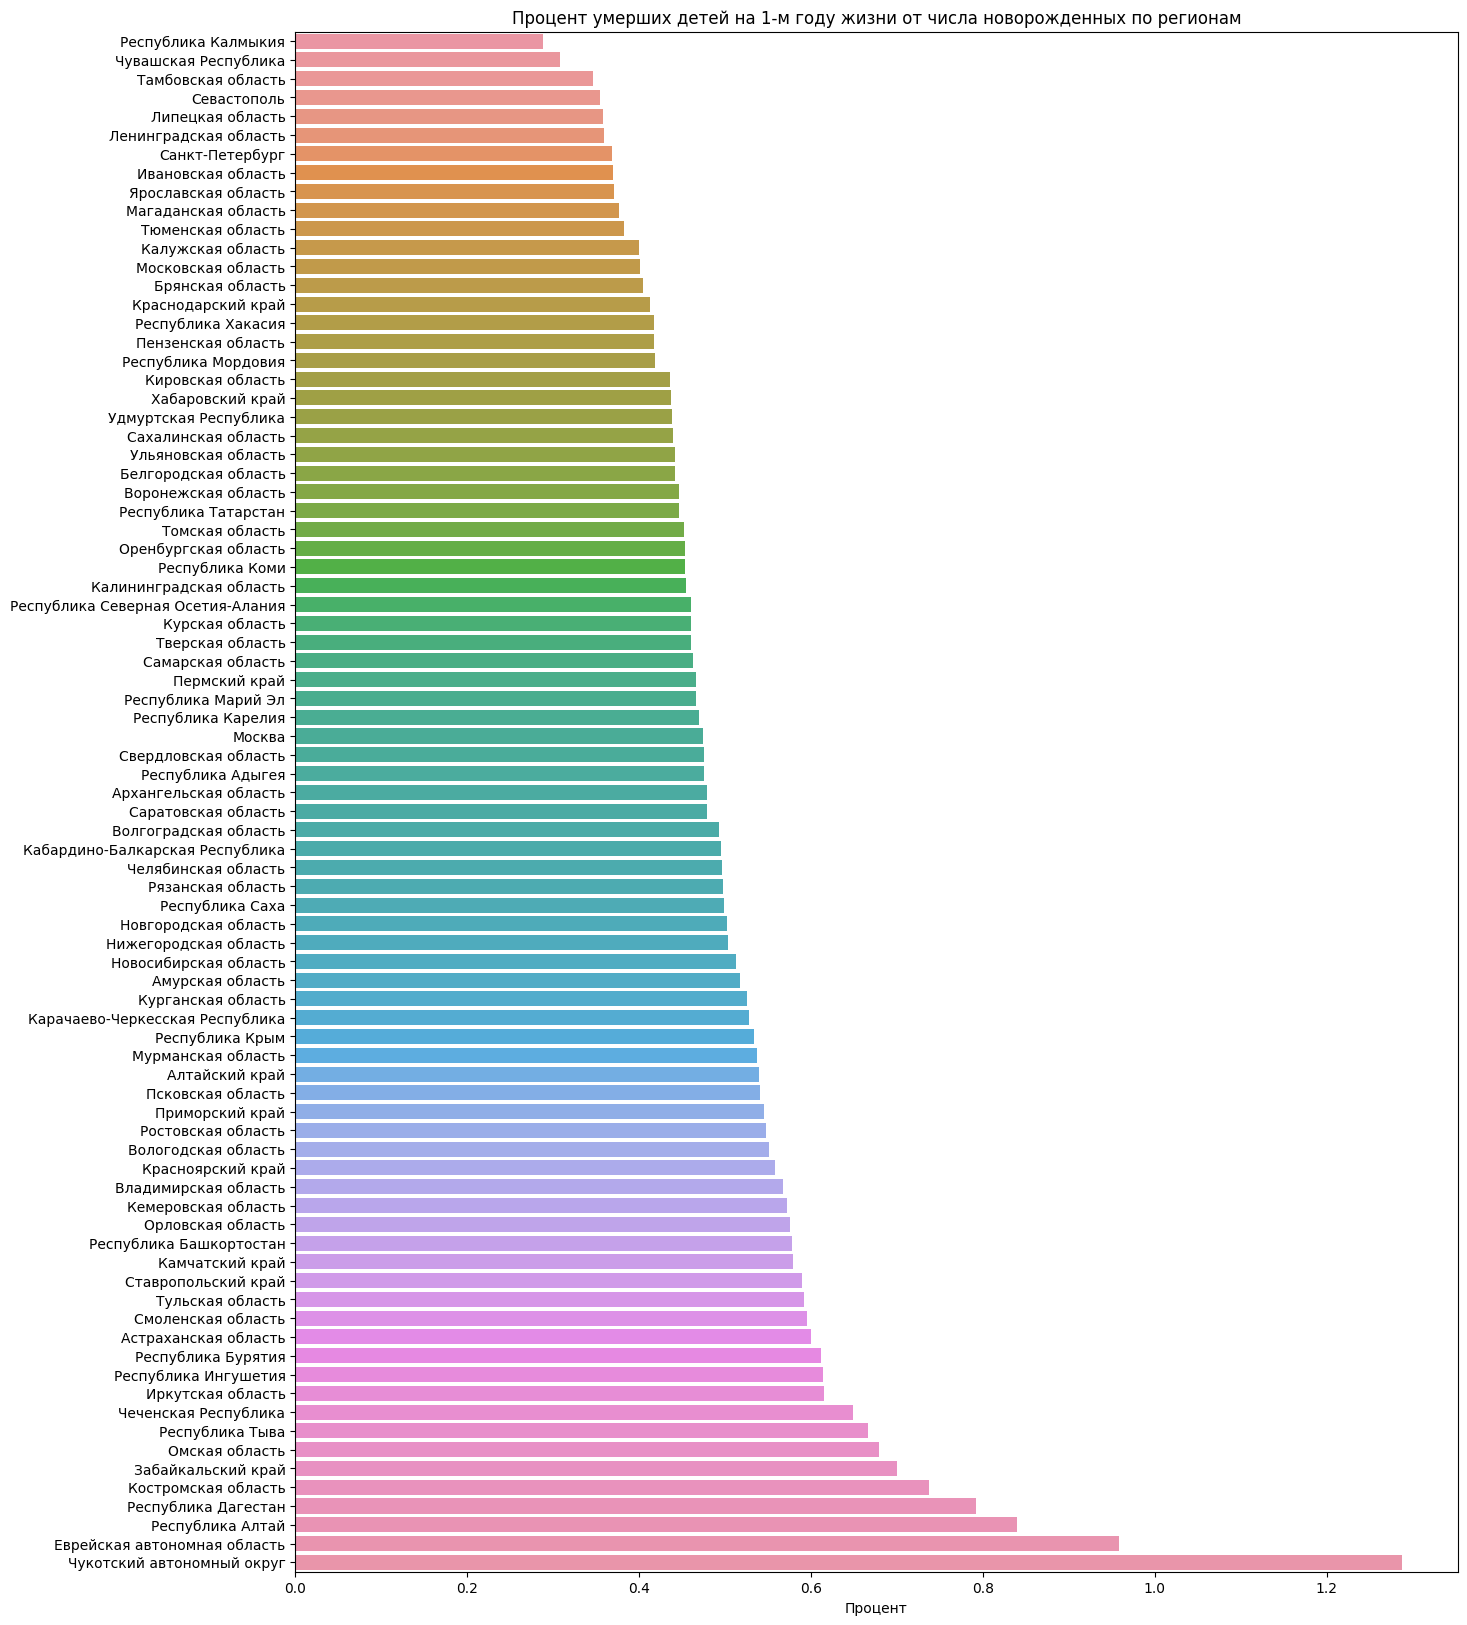

In [26]:
temp_df = child_mortality_all[['final']].sort_values(by='final', ascending=True)

fig = plt.figure(figsize=(15,20))
sns.barplot(x=temp_df['final'], y=temp_df.index)
plt.title('Процент умерших детей на 1-м году жизни от числа новорожденных по регионам')
plt.xlabel('Процент')
plt.show()

In [27]:
#заведем новый датафрейм - итоговый, в который будем собирать итоговые признаки для модели, в нем регионы отсортированы по алфавиту
final_df = pd.DataFrame(index=regions)
final_df['child_mortality'] = child_mortality_all['final']

    3. Численность населения по регионам по годам

In [28]:
population = pd.read_excel('data/population.xlsx', skiprows=[0])
population.head(5)

,Unnamed: 0,Unnamed: 1,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
0,все население,w2:p_mest:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Российская Федерация,643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Раздел 1. Муниципальные образования субъектов ...,00000000000,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
3,Центральный федеральный округ,030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Раздел 1. Муниципальные образования субъектов ...,00000000000,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0


In [29]:
#данные сьехали относительно наименований регионов, нужно корректно все сопоставить
temp = population['Unnamed: 0'].to_list()
#убираем первый и последний элемент из списка
temp.pop(0)
temp.pop()
#убираем первые две строки в таблице
population.drop(index=[0, 1], inplace=True)
population.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
population['region'] = temp
population.head()

,region,Unnamed: 1,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
2,Российская Федерация,00000000000,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
3,Раздел 1. Муниципальные образования субъектов ...,030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Центральный федеральный округ,00000000000,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0
5,Раздел 1. Муниципальные образования субъектов ...,14000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Белгородская область,00000000000,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0


In [30]:
#оставляем только строки, в которых значение столбца Unnamed: 1 равно 0000000000000 (в них есть значения)
population = population[population['Unnamed: 1'] == '00000000000']
population.drop(columns=['Unnamed: 1'], inplace=True)
population.head()

,region,январь 1999 г.,январь 2000 г.,январь 2001 г.,январь 2002 г.,январь 2003 г.,январь 2004 г.,январь 2005 г.,январь 2006 г.,январь 2007 г.,...,январь 2013 г.,январь 2014 г.,январь 2015 г.,январь 2016 г.,январь 2017 г.,январь 2018 г.,январь 2019 г.,январь 2020 г.,январь 2021 г.,январь 2022 г.
2,Российская Федерация,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,142862692.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
4,Центральный федеральный округ,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,38183357.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0
6,Белгородская область,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,1514153.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
8,Брянская область,1437471.0,1423178.0,1407965.0,1391430.0,1375004.0,1360249.0,1344132.0,1327652.0,1312748.0,...,1253666.0,1242599.0,1232940.0,1225741.0,1220530.0,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
10,Владимирская область,1592184.0,1575507.0,1558052.0,1539179.0,1520057.0,1509571.0,1497598.0,1486453.0,1475861.0,...,1421742.0,1413321.0,1405613.0,1397168.0,1389599.0,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0


In [31]:
#поменяем названия у столбцов, чтобы был просто год, как в других файлах
#при этом год уменьшаем на 1, т.к. статистика за 2021 год - это столбец "январь 2022"
def change_columns(df):
    columns = df.columns
    for column in columns:
        if column == 'region': continue
        temp = int(column.split()[1]) - 1
        df.rename(columns={column: str(temp)}, inplace=True)
    return df

In [32]:
population = change_columns(population) 
population['region'] = population['region'].apply(change_city)
population.head()

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
2,Российская Федерация,147539426.0,146890128.0,146303611.0,145649334.0,144963650.0,144333586.0,143801046.0,143236582.0,142862692.0,...,143347059.0,143666931.0,146267288.0,146544710.0,146804372.0,146880432.0,146780720.0,146748590.0,146171015.0,145557576.0
4,Центральный федеральный округ,38311159.0,38227656.0,38175094.0,38068452.0,37946810.0,37965073.0,38044068.0,38109006.0,38183357.0,...,38678913.0,38819874.0,38951479.0,39104319.0,39209582.0,39311413.0,39378059.0,39433556.0,39250960.0,39104400.0
6,Белгородская область,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,1514153.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
8,Брянская область,1437471.0,1423178.0,1407965.0,1391430.0,1375004.0,1360249.0,1344132.0,1327652.0,1312748.0,...,1253666.0,1242599.0,1232940.0,1225741.0,1220530.0,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
10,Владимирская область,1592184.0,1575507.0,1558052.0,1539179.0,1520057.0,1509571.0,1497598.0,1486453.0,1475861.0,...,1421742.0,1413321.0,1405613.0,1397168.0,1389599.0,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0


In [33]:
for item in regions:
    #проверим все ли регионы, которые мы выделили в предыдущих файлах, присутствуют в данном файле
    if item not in population['region'].unique():
        print(item)

Получается, что все регионы из предыдущего файла, есть в файле с населением

In [34]:
#отбираем нужные регионы
population = population[population['region'].isin(regions)]
population.head()

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
6,Белгородская область,1494868.0,1501699.0,1506976.0,1508137.0,1511899.0,1513860.0,1511662.0,1511715.0,1514153.0,...,1540985.0,1544108.0,1547936.0,1550137.0,1552865.0,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
8,Брянская область,1437471.0,1423178.0,1407965.0,1391430.0,1375004.0,1360249.0,1344132.0,1327652.0,1312748.0,...,1253666.0,1242599.0,1232940.0,1225741.0,1220530.0,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
10,Владимирская область,1592184.0,1575507.0,1558052.0,1539179.0,1520057.0,1509571.0,1497598.0,1486453.0,1475861.0,...,1421742.0,1413321.0,1405613.0,1397168.0,1389599.0,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0
12,Воронежская область,2458558.0,2441337.0,2422371.0,2397111.0,2374461.0,2367457.0,2364932.0,2360912.0,2353805.0,...,2330377.0,2328959.0,2331147.0,2333477.0,2335408.0,2333768.0,2327821.0,2324205.0,2305608.0,2287678.0
14,Ивановская область,1210603.0,1194595.0,1178969.0,1161861.0,1144540.0,1131027.0,1116739.0,1101862.0,1089837.0,...,1048961.0,1043130.0,1036909.0,1029838.0,1023170.0,1014646.0,1004180.0,997135.0,987032.0,976918.0


In [35]:
population.shape

(84, 25)

Получилось 84 строки, а должно быть - 82. Значит есть дубликаты - посмотрим на них

In [36]:
dubl = population[population.duplicated(subset='region')]['region'].to_list()
population[population['region'].isin(dubl)]

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
48,Архангельская область,1414144.0,1390334.0,1369118.0,1350448.0,1332655.0,1315549.0,1299218.0,1281838.0,1266667.0,...,1202295.0,1191785.0,1183323.0,1174078.0,1165750.0,1155028.0,1144119.0,1136535.0,1127051.0,1114322.0
52,Архангельская область,NaN,NaN,NaN,NaN,NaN,1273668.0,1257312.0,1239924.0,1224813.0,...,1159506.0,1148760.0,1139950.0,1130240.0,1121813.0,1111031.0,1100290.0,1092424.0,1082662.0,1069782.0
144,Тюменская область,3226093.0,3218356.0,3234252.0,3251484.0,3269862.0,3281655.0,3288337.0,3293830.0,3306698.0,...,3510683.0,3546345.0,3581293.0,3615485.0,3660030.0,3692400.0,3723969.0,3756536.0,3778053.0,3806505.0
150,Тюменская область,NaN,NaN,NaN,NaN,NaN,1317268.0,1311562.0,1308653.0,1309889.0,...,1385008.0,1409426.0,1429232.0,1454626.0,1477903.0,1498779.0,1518695.0,1537416.0,1543389.0,1552148.0


Это у нас небольшие субъекты, входящие в более крупные (они в нем посчитаны), мелкие убираем

In [37]:
population.drop_duplicates(subset='region', inplace=True)
#посмотрим на пропуски
population[population.isnull().any(axis=1)]

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
78,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1895915.0,1907106.0,1912168.0,1913731.0,1911818.0,1912622.0,1901578.0,1896393.0
88,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,398973.0,416263.0,428753.0,436670.0,443212.0,449138.0,509992.0,522057.0


Есть пропущенные значения по 2 субьектам, это Крым и Севастополь, но это данные до 2014 года.
Как и с предыдущими файлами, возьмем последние 5 лет

In [38]:
for column in population.columns:
    if column == 'region': continue
    if int(column) < 2017:
        population.drop(columns=column, inplace=True)
population.head()

,region,2017,2018,2019,2020,2021
6,Белгородская область,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0
8,Брянская область,1210982.0,1200187.0,1192491.0,1182682.0,1168771.0
10,Владимирская область,1378337.0,1365805.0,1358416.0,1342099.0,1323659.0
12,Воронежская область,2333768.0,2327821.0,2324205.0,2305608.0,2287678.0
14,Ивановская область,1014646.0,1004180.0,997135.0,987032.0,976918.0


In [39]:
population.sort_values(by='region', inplace=True)
population.index = population['region']
population.drop(columns='region', inplace=True)
for ind in population.index:
    population.loc[ind, 'total'] = population.loc[ind, ['2017', '2018', '2019', '2020', '2021']].mean()
population.head()

,2017,2018,2019,2020,2021,total
region,,,,,,
Алтайский край,2350080.0,2332813.0,2317153.0,2296353.0,2268179.0,2312915.6
Амурская область,798424.0,793194.0,790044.0,781846.0,772525.0,787206.6
Архангельская область,1155028.0,1144119.0,1136535.0,1127051.0,1114322.0,1135411.0
Астраханская область,1017514.0,1014065.0,1005782.0,997778.0,989430.0,1004913.8
Белгородская область,1549876.0,1547418.0,1549151.0,1541259.0,1531917.0,1543924.2


    Посчитаем процентное соотношение новорожденных к общему количеству, проживающих в регионе

In [40]:
birth_rate = pd.DataFrame(index=newborn.index, columns=newborn.columns)
for column in birth_rate.columns:
    birth_rate[column] = (newborn[column] / population[column]) * 1000

final = []
for ind in birth_rate.index:
    final.append(birth_rate.loc[ind, :].median())
birth_rate['final'] = final

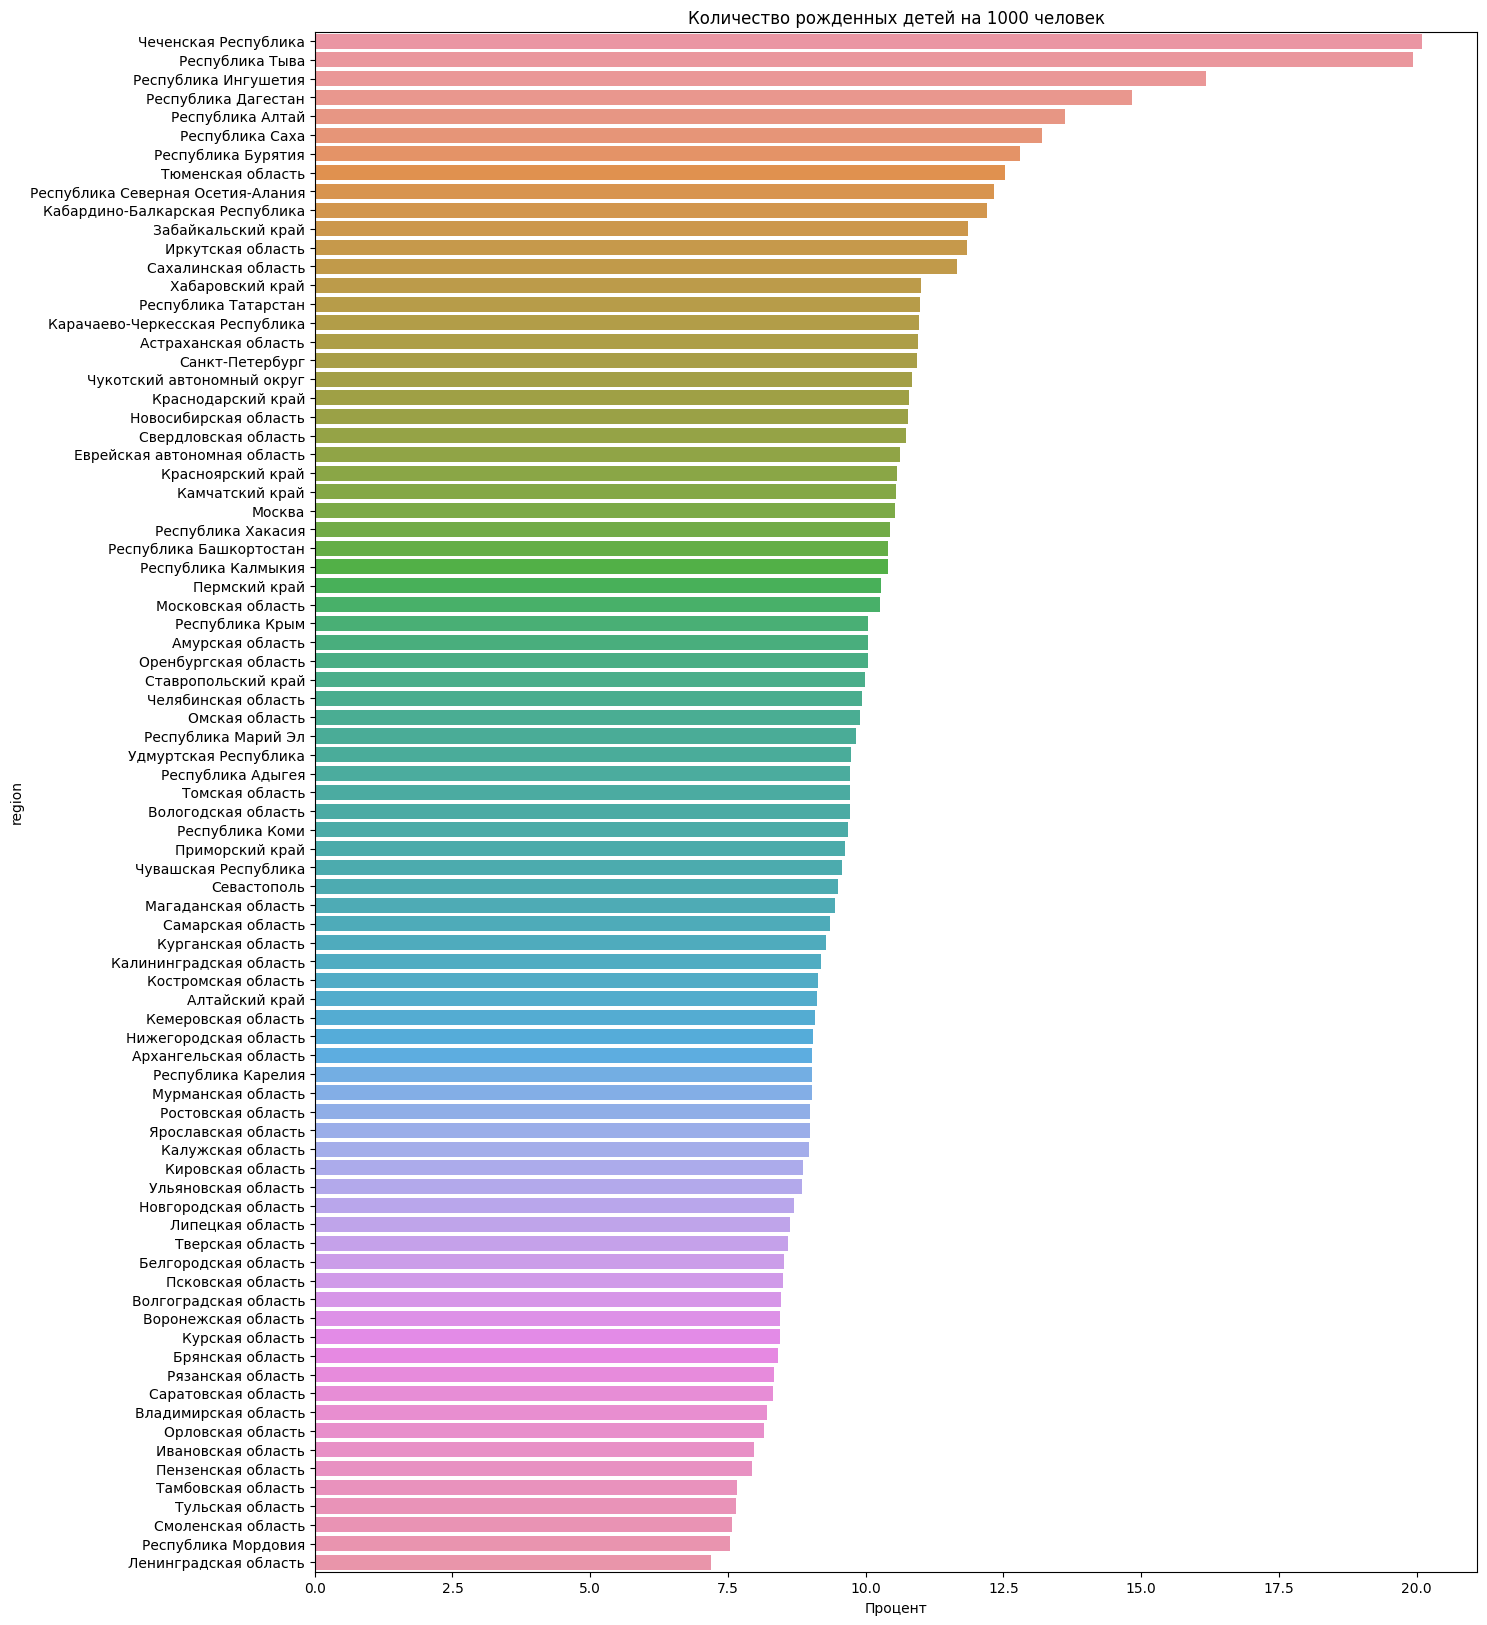

In [41]:
temp_df = birth_rate[['final']].sort_values(by='final', ascending=False)

fig = plt.figure(figsize=(15,20))
sns.barplot(x=temp_df['final'], y=temp_df.index)
plt.title('Количество рожденных детей на 1000 человек')
plt.xlabel('Процент')
plt.show()

In [42]:
final_df['birth_rate'] = birth_rate['final']

    4. Число людей с инвалидностью по регионам, по месяцам, по возрастным группам

In [43]:
disable_total = pd.read_csv('data/disabled_total_by_age_2017_2022.csv', parse_dates=['date'], dayfirst=True)
disable_total['region'] = disable_total['region'].apply(change_city)
disable_total.head()

,region,total,18_30,31_40,41_50,51_60,60_,date
0,Российская Федерация,11640873.0,550895.0,766054.0,1030652.0,2135436.0,7157836.0,2017-01-01
1,Центральный федеральный округ,3420310.0,118579.0,172662.0,257484.0,598102.0,2273483.0,2017-01-01
2,Белгородская область,223030.0,6318.0,10383.0,16596.0,37444.0,152289.0,2017-01-01
3,Брянская область,110418.0,4215.0,6568.0,10230.0,21481.0,67924.0,2017-01-01
4,Владимирская область,133352.0,4454.0,6811.0,9606.0,23322.0,89159.0,2017-01-01


In [44]:
disable_total = disable_total[disable_total['region'].apply(lambda x: True if x in regions else False)]
disable_total = disable_total.groupby(by=['region'], as_index=False).median()     
disable_total

,region,total,18_30,31_40,41_50,51_60,60_
0,Алтайский край,174569.0,7343.0,13482.0,15305.0,25683.0,112443.0
1,Амурская область,65390.0,3273.0,5283.5,6272.0,10596.5,39856.5
2,Архангельская область,85858.5,2979.5,5153.0,6835.5,12276.5,58440.5
3,Астраханская область,43570.5,2705.5,3981.5,4758.0,8215.5,23729.0
4,Белгородская область,203215.0,5203.5,9799.5,15197.0,31804.0,141197.0
...,...,...,...,...,...,...,...
77,Челябинская область,220348.5,10798.0,15631.0,18900.5,34193.5,140595.5
78,Чеченская Республика,163479.5,23923.5,37862.0,39647.5,35680.0,26509.0
79,Чувашская Республика,77935.5,3524.5,5122.5,7140.5,13523.0,48379.5
80,Чукотский автономный округ,1629.5,175.0,223.0,277.0,392.0,561.5


In [45]:
disable_total.index = disable_total['region']
disable_total.drop(columns='region', inplace=True)
disable_total.head()

,total,18_30,31_40,41_50,51_60,60_
region,,,,,,
Алтайский край,174569.0,7343.0,13482.0,15305.0,25683.0,112443.0
Амурская область,65390.0,3273.0,5283.5,6272.0,10596.5,39856.5
Архангельская область,85858.5,2979.5,5153.0,6835.5,12276.5,58440.5
Астраханская область,43570.5,2705.5,3981.5,4758.0,8215.5,23729.0
Белгородская область,203215.0,5203.5,9799.5,15197.0,31804.0,141197.0


Сами по себе данные нам ничего не говорят, имеет смысл рассматривать в виде процента от общего населения региона

In [46]:
final_df['disable'] = (disable_total['total'] / population['total']) * 100

    5. Процент людей, живущих за чертой бедности

In [47]:
poverty = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
poverty.head()

,region,year,poverty_percent
0,Российская Федерация,1992,33.5
1,Российская Федерация,1993,31.3
2,Российская Федерация,1994,22.4
3,Российская Федерация,1995,24.8
4,Российская Федерация,1996,22.1


In [48]:
poverty = poverty[poverty['region'].apply(change_region)]
poverty['region'] = poverty['region'].apply(change_city)
poverty = poverty[poverty['region'].isin(regions)]
poverty.head()

,region,year,poverty_percent
45,Белгородская область,1995,19.9
46,Белгородская область,1996,17.6
47,Белгородская область,1997,18.9
48,Белгородская область,1998,20.1
49,Белгородская область,1999,24.2


Пропущенных значений нет. Найдем для каждого региона среднее, но за последние 5 лет

In [49]:
poverty = poverty[poverty['year'] >= 2016]
poverty

,region,year,poverty_percent
66,Белгородская область,2016,8.1
67,Белгородская область,2017,7.8
68,Белгородская область,2018,7.5
69,Белгородская область,2019,7.8
70,Белгородская область,2020,7.2
...,...,...,...
2333,Чукотский автономный округ,2016,8.6
2334,Чукотский автономный округ,2017,8.5
2335,Чукотский автономный округ,2018,8.8
2336,Чукотский автономный округ,2019,8.5


In [50]:
poverty.groupby(by='region')['poverty_percent'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Алтайский край,5.0,17.56,0.151658,17.4,17.5,17.5,17.6,17.8
Амурская область,5.0,16.04,0.770065,15.2,15.6,15.7,16.7,17.0
Архангельская область,5.0,13.88,0.909395,12.8,13.5,13.6,14.3,15.2
Астраханская область,5.0,15.56,0.357771,15.1,15.5,15.5,15.6,16.1
Белгородская область,5.0,7.68,0.342053,7.2,7.5,7.8,7.8,8.1
...,...,...,...,...,...,...,...,...
Челябинская область,5.0,13.04,0.477493,12.6,12.8,12.8,13.2,13.8
Чеченская Республика,5.0,19.92,1.470374,17.3,20.4,20.5,20.7,20.7
Чувашская Республика,5.0,17.84,0.792465,16.8,17.4,17.8,18.4,18.8


In [51]:
final_df['poverty'] = poverty.groupby(by='region')['poverty_percent'].mean()

    6. Расходы на социальную политику от общих расходов

In [52]:
welfare_expense = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')
welfare_expense

,region,2015,2016,2017,2018,2019,2020
0,Российская Федерация,15.8,16.6,20.4,20.3,19.8,21.3
1,Центральный\n федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN
2,Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1
3,Брянская область,22.0,26.6,24.7,23.7,20.7,23.1
4,Владимирская область,18.1,18.0,24.0,23.4,23.4,26.0
...,...,...,...,...,...,...,...
89,Амурская область,19.2,28.9,26.3,24.1,22.7,21.7
90,Магаданская область,9.8,10.6,13.4,12.8,12.3,11.1
91,Сахалинская область,6.4,9.9,16.8,14.3,13.8,16.5
92,Еврейская автономная область,18.4,17.7,28.3,27.8,25.7,31.2


In [53]:
welfare_expense['region'] = welfare_expense['region'].map(lambda x: str(x).replace('\n', ' '))
welfare_expense['region'] = welfare_expense['region'].map(lambda x: change_city(x))
welfare_expense = welfare_expense[welfare_expense['region'].isin(regions)]
welfare_expense

,region,2015,2016,2017,2018,2019,2020
2,Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1
3,Брянская область,22.0,26.6,24.7,23.7,20.7,23.1
4,Владимирская область,18.1,18.0,24.0,23.4,23.4,26.0
5,Воронежская область,15.2,15.4,22.8,20.9,19.0,21.6
6,Ивановская область,18.1,28.9,28.7,27.0,25.1,25.1
...,...,...,...,...,...,...,...
89,Амурская область,19.2,28.9,26.3,24.1,22.7,21.7
90,Магаданская область,9.8,10.6,13.4,12.8,12.3,11.1
91,Сахалинская область,6.4,9.9,16.8,14.3,13.8,16.5
92,Еврейская автономная область,18.4,17.7,28.3,27.8,25.7,31.2


In [54]:
welfare_expense = welfare_expense.sort_values(by='region')
welfare_expense.index = welfare_expense['region']
welfare_expense = welfare_expense.drop(columns=[2015, 'region'])
temp = []
for ind in welfare_expense.index:
    temp.append(welfare_expense.loc[ind, [2016, 2017, 2018, 2019, 2020]].mean())
final_df['welfare'] = temp

    7. Доходы населения

In [55]:
sheets = {'cash_income': 'per_capita_cash_income', 'real_income': 'real_incomes', 
          'formal_wage': 'formal_wage_paid', 'real_pay': 'real_pay'}

In [56]:
wages = {}
temp = {}
for key in sheets.keys():
    wages[key] = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', sheet_name=sheets[key])
    wages[key]['region'] = wages[key]['region'].map(lambda x: str(x).replace('\n', ' '))
    wages[key]['region'] = wages[key]['region'].map(lambda x: change_city(x))
    wages[key] = wages[key][wages[key]['region'].isin(regions)]
    wages[key] = wages[key].drop(columns=2015)
    wages[key] = wages[key].drop_duplicates(subset='region')
    wages[key] = wages[key].sort_values(by='region')
    wages[key].index = wages[key]['region']
    wages[key] = wages[key].drop(columns='region')
    temp[key] = []
    for ind in wages[key].index:
        temp[key].append(wages[key].loc[ind, :].mean())

In [57]:
wages['cash_income']

,2016,2017,2018,2019,2020
region,,,,,
Алтайский край,21256.0,22139.0,22829.0,23937.0,23864.0
Амурская область,27976.0,29213.0,30937.0,33304.0,35499.0
Архангельская область,31394.0,32310.0,33831.0,35693.0,36779.0
Астраханская область,22841.0,22884.0,23670.0,24971.0,25199.0
Белгородская область,29799.0,30342.0,30778.0,32352.0,32841.0
...,...,...,...,...,...
Челябинская область,23657.0,23719.0,24386.0,25425.0,26628.0
Чеченская Республика,22859.0,22484.0,23197.0,24138.0,24596.0
Чувашская Республика,17646.0,17952.0,18462.0,20162.0,21155.0


In [58]:
wages_total = pd.DataFrame(index=regions, data=temp)
wages_total

,cash_income,real_income,formal_wage,real_pay
Алтайский край,22805.0,97.90,25499.6,104.00
Амурская область,31385.8,99.52,42636.8,104.94
Архангельская область,34001.4,98.50,48074.4,103.72
Астраханская область,23913.0,97.12,33140.0,104.82
Белгородская область,31222.4,99.46,32013.2,104.18
...,...,...,...,...
Челябинская область,24763.0,97.56,35039.0,101.90
Чеченская Республика,23454.8,99.08,25976.0,101.86
Чувашская Республика,19075.4,99.32,27197.8,104.62
Чукотский автономный округ,78492.6,102.40,101050.8,104.02


In [59]:
final_df['wages'] = wages_total['cash_income']

    8. Распределение малоимущего населения по социально-демографическим группам

In [60]:
socdem = pd.read_excel('data/poverty_socdem_2018.xls', skiprows=[0, 1])
socdem.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
socdem.drop(columns='Все население', inplace=True)
socdem['region'] = socdem['region'].apply(change_city)
socdem = socdem[socdem['region'].isin(regions)]
socdem.drop_duplicates(subset='region', inplace=True)
socdem

,region,Дети в возрасте до 16 лет,Население старше трудоспособного возраста,Население трудоспособного возраста
1,Белгородская область,44.8,12.9,42.3
2,Брянская область,40.3,1.8,57.9
3,Владимирская область,48.9,8.3,42.8
4,Воронежская область,32.6,8.0,59.4
5,Ивановская область,31.2,9.5,59.3
...,...,...,...,...
83,Амурская область,40.6,4.6,54.8
84,Магаданская область,30.7,11.5,57.8
85,Сахалинская область,32.9,4.3,62.8
86,Еврейская автономная область,33.7,7.4,58.9


В 2019 и 2020 году по некоторым регионам либо нет данных, либо нулевые, поэтому возьмем за основу 2018 год

In [61]:
socdem = socdem.sort_values(by='region')
socdem.index = socdem['region']
socdem.drop(columns='region', inplace=True)
socdem.columns = ['Дети', 'Пенсионеры', 'Трудоспособные']
socdem

,Дети,Пенсионеры,Трудоспособные
region,,,
Алтайский край,42.1,5.1,52.8
Амурская область,40.6,4.6,54.8
Архангельская область,39.5,6.5,54.0
Астраханская область,35.0,5.2,59.8
Белгородская область,44.8,12.9,42.3
...,...,...,...
Челябинская область,44.2,3.2,52.6
Чеченская Республика,46.0,5.5,48.5
Чувашская Республика,40.5,7.3,52.2


In [62]:
socdem['Дети'] = socdem['Дети'] / 100
socdem['Пенсионеры'] = socdem['Пенсионеры'] / 100

Чтобы понимать какая категория жителей наиболее нуждается в помощи, возьмем в итоговую таблицу отдельно показатель по детям и людям пожилого возраста

In [63]:
final_df['socdem_child'] = socdem['Дети']
final_df['socdem_old'] = socdem['Пенсионеры']

    9. Характеристика жилищных условий домохозяйств

In [64]:
housing = pd.read_excel('data/housing_2020.xlsx')
housing

,Регион,"Число домохозяйств, проживающих во всех типах жилых помещений","в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности","в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность","в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность",затруднились ответить,Размер общей площади в расчете на члена домохозяйства,Размер жилой площади в расчете на члена домохозяйства,Число жилых комнат в расчете на одно домохозяйство
0,Российская Федерация,100.0,80.7,15.4,3.8,0.1,24.2,16.9,2.4
1,Центральный федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Белгородская область,100.0,86.3,11.7,2.0,0.0,25.1,17.8,2.6
3,Брянская область,100.0,94.7,4.6,0.6,0.0,30.5,24.1,3.2
4,Bладимирская область,100.0,81.8,15.8,2.5,0.0,24.2,16.1,2.2
...,...,...,...,...,...,...,...,...,...
89,Амурская область,100.0,77.3,16.8,5.9,0.0,23.2,17.3,2.3
90,Магаданская область,100.0,80.3,15.7,4.1,0.0,23.7,13.8,1.9
91,Сахалинская область,100.0,84.3,13.2,2.5,0.0,22.5,17.2,2.1
92,Еврейская авт. область,100.0,82.2,13.1,4.6,0.0,20.1,13.8,2.2


In [65]:
housing['Регион'] = housing['Регион'].apply(change_city)
for region in regions:
    if region not in housing['Регион'].values:
        print(region)

Архангельская область
Владимирская область
Волгоградская область
Вологодская область
Воронежская область
Тюменская область


In [66]:
hous_region = housing['Регион'].values.tolist()
len(hous_region)
for reg in regions:
    for item in hous_region:
        ind = hous_region.index(item)
        if item.find(reg) != -1:
            if item != reg:
                hous_region[ind] = reg
        tmp = hous_region[ind].replace('B', 'В') #обнаружена латинская B вместо русской В в некоторых названиях
        hous_region[ind] = tmp
housing['Регион'] = hous_region

In [67]:

housing = housing[housing['Регион'].isin(regions)]
housing = housing.drop_duplicates(subset='Регион')
housing

,Регион,"Число домохозяйств, проживающих во всех типах жилых помещений","в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности","в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность","в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность",затруднились ответить,Размер общей площади в расчете на члена домохозяйства,Размер жилой площади в расчете на члена домохозяйства,Число жилых комнат в расчете на одно домохозяйство
2,Белгородская область,100.0,86.3,11.7,2.0,0.0,25.1,17.8,2.6
3,Брянская область,100.0,94.7,4.6,0.6,0.0,30.5,24.1,3.2
4,Владимирская область,100.0,81.8,15.8,2.5,0.0,24.2,16.1,2.2
5,Воронежская область,100.0,87.0,11.4,1.6,0.1,29.0,19.9,2.6
6,Ивановская область,100.0,76.9,19.1,3.9,0.0,25.2,18.1,2.4
...,...,...,...,...,...,...,...,...,...
89,Амурская область,100.0,77.3,16.8,5.9,0.0,23.2,17.3,2.3
90,Магаданская область,100.0,80.3,15.7,4.1,0.0,23.7,13.8,1.9
91,Сахалинская область,100.0,84.3,13.2,2.5,0.0,22.5,17.2,2.1
92,Еврейская автономная область,100.0,82.2,13.1,4.6,0.0,20.1,13.8,2.2


In [68]:
housing = housing.sort_values(by='Регион')
housing.index = housing['Регион']
housing.drop(columns='Регион', inplace=True)
housing

,"Число домохозяйств, проживающих во всех типах жилых помещений","в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности","в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность","в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность",затруднились ответить,Размер общей площади в расчете на члена домохозяйства,Размер жилой площади в расчете на члена домохозяйства,Число жилых комнат в расчете на одно домохозяйство
Регион,,,,,,,,
Алтайский край,100.0,83.2,13.4,3.3,0.1,25.9,18.0,2.4
Амурская область,100.0,77.3,16.8,5.9,0.0,23.2,17.3,2.3
Архангельская область,100.0,83.3,14.5,2.2,0.0,24.6,16.9,2.4
Астраханская область,100.0,77.5,19.4,3.1,0.0,24.9,19.2,2.3
Белгородская область,100.0,86.3,11.7,2.0,0.0,25.1,17.8,2.6
...,...,...,...,...,...,...,...,...
Челябинская область,100.0,78.6,16.5,4.9,0.0,23.6,16.0,2.2
Чеченская Республика,100.0,80.4,18.2,1.4,0.0,24.6,19.2,4.3
Чувашская Республика,100.0,72.0,20.0,8.0,0.0,20.7,14.2,2.3


In [69]:
housing.isnull().sum()

Число домохозяйств, проживающих во всех типах жилых помещений                                    0
в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности              0
в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность    0
в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность         0
затруднились ответить                                                                            0
Размер общей площади в расчете на члена домохозяйства                                            0
Размер жилой площади в расчете на члена домохозяйства                                            0
Число жилых комнат в расчете на одно домохозяйство                                               0
dtype: int64

пропущенных значений нет

In [70]:
final_df['housing'] = housing['Размер жилой площади в расчете на члена домохозяйства']

    10. Валовый региональный продукт на душу населения

In [71]:
product = pd.read_excel('data/gross_regional_product_1996_2020.xls', skiprows=[1, 2])
product

,"Валовой региональный продукт на душу населения (рубль, значение показателя за год)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Российская Федерация,12225.0,13938.4,15371.1,26200.6,39532.3,49474.8,60611.4,74840.5,97691.9,...,317515.3,348641.5,377006.0,405147.7,449097.9,505337.7,543065.9,614333.2,646144.1,640519.0
1,Центральный федеральный округ,NaN,NaN,16564.4,31118.7,48205.0,58851.5,75739.2,94244.6,121487.7,...,417288.1,451517.2,494482.7,536607.9,580706.6,663881.8,711031.6,792780.9,835858.8,854978.5
2,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
3,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
4,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Магаданская область,26438.6,30770.0,32315.5,50936.4,65704.6,89987.5,121272.5,135180.6,139840.3,...,464112.9,511125.4,587477.4,649745.4,854561.5,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
97,Сахалинская область,15476.9,19625.3,21428.2,45662.9,61595.8,84769.1,85927.4,116731.0,172004.4,...,1210003.9,1298440.0,1364874.7,1631919.0,1716734.4,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5
98,Еврейская автономная область,7177.0,8355.6,7535.3,15344.9,19484.8,24877.5,35766.0,45196.1,60029.9,...,225065.5,246301.3,224042.7,247666.9,266405.8,294021.2,338826.6,339068.1,355545.7,400340.5
99,Чукотский автономный округ,30606.1,33540.9,37859.4,49746.0,65963.0,123130.9,187368.1,256992.1,238227.2,...,883368.7,896822.1,877612.8,1142504.1,1226152.0,1443771.7,1469675.0,1685134.1,1898634.8,2404271.2


In [72]:
new_col = []
new_col.append('region')
for i in range(1996, 2021):
    new_col.append(str(i))
product.columns = new_col
product

,region,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Российская Федерация,12225.0,13938.4,15371.1,26200.6,39532.3,49474.8,60611.4,74840.5,97691.9,...,317515.3,348641.5,377006.0,405147.7,449097.9,505337.7,543065.9,614333.2,646144.1,640519.0
1,Центральный федеральный округ,NaN,NaN,16564.4,31118.7,48205.0,58851.5,75739.2,94244.6,121487.7,...,417288.1,451517.2,494482.7,536607.9,580706.6,663881.8,711031.6,792780.9,835858.8,854978.5
2,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
3,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
4,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Магаданская область,26438.6,30770.0,32315.5,50936.4,65704.6,89987.5,121272.5,135180.6,139840.3,...,464112.9,511125.4,587477.4,649745.4,854561.5,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
97,Сахалинская область,15476.9,19625.3,21428.2,45662.9,61595.8,84769.1,85927.4,116731.0,172004.4,...,1210003.9,1298440.0,1364874.7,1631919.0,1716734.4,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5
98,Еврейская автономная область,7177.0,8355.6,7535.3,15344.9,19484.8,24877.5,35766.0,45196.1,60029.9,...,225065.5,246301.3,224042.7,247666.9,266405.8,294021.2,338826.6,339068.1,355545.7,400340.5
99,Чукотский автономный округ,30606.1,33540.9,37859.4,49746.0,65963.0,123130.9,187368.1,256992.1,238227.2,...,883368.7,896822.1,877612.8,1142504.1,1226152.0,1443771.7,1469675.0,1685134.1,1898634.8,2404271.2


In [73]:
product['region'] = product['region'].apply(change_city)
product = product[product['region'].isin(regions)]
product

,region,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
3,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
4,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
5,Воронежская область,7651.9,8686.6,9082.1,14808.3,20365.1,24905.4,34789.6,42237.5,49530.0,...,203575.5,241947.4,262578.3,308004.7,345566.8,354657.9,374125.7,408140.7,431037.0,459629.5
6,Ивановская область,6725.4,6379.3,6804.5,9765.2,14240.0,18947.2,23396.9,29192.4,35732.7,...,121945.5,129448.3,151263.6,146032.6,174687.5,200504.4,208522.0,230325.5,249591.6,273821.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Амурская область,13155.7,15818.0,15103.7,21935.4,28317.2,42578.3,50449.6,59480.3,72937.0,...,273175.8,280023.9,258817.0,286282.6,343385.7,370192.4,373935.1,419905.2,521060.1,571362.1
96,Магаданская область,26438.6,30770.0,32315.5,50936.4,65704.6,89987.5,121272.5,135180.6,139840.3,...,464112.9,511125.4,587477.4,649745.4,854561.5,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
97,Сахалинская область,15476.9,19625.3,21428.2,45662.9,61595.8,84769.1,85927.4,116731.0,172004.4,...,1210003.9,1298440.0,1364874.7,1631919.0,1716734.4,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5
98,Еврейская автономная область,7177.0,8355.6,7535.3,15344.9,19484.8,24877.5,35766.0,45196.1,60029.9,...,225065.5,246301.3,224042.7,247666.9,266405.8,294021.2,338826.6,339068.1,355545.7,400340.5


In [74]:
product = product.drop_duplicates(subset='region')
product

,region,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
3,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
4,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
5,Воронежская область,7651.9,8686.6,9082.1,14808.3,20365.1,24905.4,34789.6,42237.5,49530.0,...,203575.5,241947.4,262578.3,308004.7,345566.8,354657.9,374125.7,408140.7,431037.0,459629.5
6,Ивановская область,6725.4,6379.3,6804.5,9765.2,14240.0,18947.2,23396.9,29192.4,35732.7,...,121945.5,129448.3,151263.6,146032.6,174687.5,200504.4,208522.0,230325.5,249591.6,273821.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Амурская область,13155.7,15818.0,15103.7,21935.4,28317.2,42578.3,50449.6,59480.3,72937.0,...,273175.8,280023.9,258817.0,286282.6,343385.7,370192.4,373935.1,419905.2,521060.1,571362.1
96,Магаданская область,26438.6,30770.0,32315.5,50936.4,65704.6,89987.5,121272.5,135180.6,139840.3,...,464112.9,511125.4,587477.4,649745.4,854561.5,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
97,Сахалинская область,15476.9,19625.3,21428.2,45662.9,61595.8,84769.1,85927.4,116731.0,172004.4,...,1210003.9,1298440.0,1364874.7,1631919.0,1716734.4,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5
98,Еврейская автономная область,7177.0,8355.6,7535.3,15344.9,19484.8,24877.5,35766.0,45196.1,60029.9,...,225065.5,246301.3,224042.7,247666.9,266405.8,294021.2,338826.6,339068.1,355545.7,400340.5


In [75]:
#оставим последние 5 лет и возьмем среднее значение
for column in product.drop(columns='region').columns:
    if int(column) < 2016:
        product = product.drop(columns=column)
product

,region,2016,2017,2018,2019,2020
2,Белгородская область,501467.8,539720.5,588641.5,617426.5,646569.0
3,Брянская область,258752.7,280630.1,304547.1,332442.8,347204.5
4,Владимирская область,309713.7,325043.1,349856.4,394560.3,410443.6
5,Воронежская область,354657.9,374125.7,408140.7,431037.0,459629.5
6,Ивановская область,200504.4,208522.0,230325.5,249591.6,273821.5
...,...,...,...,...,...,...
95,Амурская область,370192.4,373935.1,419905.2,521060.1,571362.1
96,Магаданская область,1054274.8,1117517.3,1236274.4,1518066.7,2035007.0
97,Сахалинская область,1564707.9,1605079.4,2517125.0,2400858.1,2059206.5
98,Еврейская автономная область,294021.2,338826.6,339068.1,355545.7,400340.5


In [76]:
product = product.sort_values(by='region')
product.index = product['region']
product = product.drop(columns='region')
product

,2016,2017,2018,2019,2020
region,,,,,
Алтайский край,224525.8,231268.4,247599.3,271319.7,291156.9
Амурская область,370192.4,373935.1,419905.2,521060.1,571362.1
Архангельская область,609484.0,654268.9,753081.9,780623.9,697648.2
Астраханская область,361704.8,434701.5,570206.4,596388.2,526950.9
Белгородская область,501467.8,539720.5,588641.5,617426.5,646569.0
...,...,...,...,...,...
Челябинская область,380623.8,405015.2,436611.1,445276.7,467537.3
Чеченская Республика,143561.5,151464.0,154705.5,164617.3,171029.5
Чувашская Республика,230260.9,240379.6,257992.5,278358.9,287210.3


In [77]:
product['total'] = product.mean(axis=1)
final_df['product'] = product['total'] / 1000

    11. Объем отгруженных товаров собственного производства или работ, выполненных собственными силами

In [78]:
production = pd.read_csv('data/regional_production_2017_2020.csv')
production

,region,production_field,2017,2018,2019,2020
0,Российская Федерация,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,1.391616e+10,1.819387e+10,1.832413e+10,1.449890e+10
1,Российская Федерация,Добыча угля,1.228407e+09,1.567151e+09,1.392654e+09,1.100662e+09
2,Российская Федерация,Добыча и обогащение угля и антрацита,1.151523e+09,1.472893e+09,1.302804e+09,1.012754e+09
3,Российская Федерация,Добыча и обогащение бурого угля (лигнита),7.688374e+07,9.425728e+07,8.984967e+07,8.790853e+07
4,Российская Федерация,Добыча нефти и природного газа,9.286030e+09,1.287361e+10,1.285934e+10,8.945390e+09
...,...,...,...,...,...,...
599,Чукотский автономный округ,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,6.531643e+07,6.750155e+07,1.468094e+07,2.313692e+07
600,Чукотский автономный округ,ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА,1.023386e+06,1.055402e+06,6.734268e+07,9.323680e+07
601,Чукотский автономный округ,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...",7.796269e+06,8.805295e+06,9.436014e+06,1.362003e+07
602,Чукотский автономный округ,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...",2.878372e+05,4.908262e+05,6.054902e+05,6.473567e+05


In [79]:
production['region'] = production['region'].apply(change_city)
production = production[production['region'].isin(regions)]
production

,region,production_field,2017,2018,2019,2020
138,Белгородская область,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,116588313.5,1.488634e+08,1.783899e+08,1.898038e+08
139,Белгородская область,ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА,629092604.8,7.108288e+08,7.226997e+08,7.463807e+08
140,Белгородская область,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...",27030715.9,2.680549e+07,2.654258e+07,2.678738e+07
141,Белгородская область,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...",10614103.8,8.936415e+06,1.140417e+07,1.117503e+07
142,Белгородская область,Промышленное производство (промышленность),783325738.0,8.954341e+08,9.390364e+08,9.741469e+08
...,...,...,...,...,...,...
599,Чукотский автономный округ,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,65316434.2,6.750155e+07,1.468094e+07,2.313692e+07
600,Чукотский автономный округ,ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА,1023385.9,1.055402e+06,6.734268e+07,9.323680e+07
601,Чукотский автономный округ,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...",7796269.3,8.805295e+06,9.436014e+06,1.362003e+07
602,Чукотский автономный округ,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...",287837.2,4.908262e+05,6.054902e+05,6.473567e+05


In [80]:
production = production.drop_duplicates(subset=['region', 'production_field'])
production = production.sort_values(by=['region', 'production_field'])
type_production = production['production_field'].value_counts().index
type_production

Index(['ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА',
       'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
       'Промышленное производство (промышленность)',
       'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ',
       'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'],
      dtype='object')

Получено 4 типа деятельности

In [81]:
production_total = pd.DataFrame(index=regions, columns=type_production)
for type in type_production:
    tmp = production[production['production_field'] == type].copy()
    tmp.index = tmp['region'].values
    tmp.drop(columns=['region', 'production_field'], inplace=True)
    production_total[type] = tmp.mean(axis=1)

In [82]:
production_total['total'] = production_total.sum(axis=1) / 1000000
production_total.sort_values(by='total', ascending=False)['total']

Москва                          18317.137701
Тюменская область               15908.362469
Московская область               6307.575043
Санкт-Петербург                  5654.678873
Республика Татарстан             5312.147105
                                    ...     
Севастополь                        51.775355
Еврейская автономная область       47.345470
Республика Алтай                   19.113418
Республика Ингушетия               10.038200
Республика Калмыкия                 9.786325
Name: total, Length: 82, dtype: float64

In [83]:
final_df['production'] = production_total['total']

    12. Оборот розничной торговли на душу населения

In [84]:
retail = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', skiprows=[0, 1])
retail = retail.drop(index=0)
retail.rename(columns={'Unnamed: 0': 'region'}, inplace=True)
retail = retail.drop(columns='Unnamed: 1')
retail

,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Российская Федерация,16046,21031,25913,31557,39166,49063,60901,76111,97688,...,149401,165051,180410,188017,192541,202568,215074,229104,231283,270606
2,Центральный федеральный округ,26062,33630,40010,46760,57011,68302,81774,97965,121934,...,188757,207394,231873,237737,243426,258278,277011,296368,301192,354141
3,Белгородская область,11820,13837,16366,19222,24168,30174,41387,55460,74599,...,129904,144992,164079,178097,192504,203298,217059,230704,237076,259151
4,Брянская область,8267,10951,14312,17988,22849,28892,36931,48448,64977,...,121136,138669,158501,177048,179767,192775,209987,225818,225643,257679
5,Владимирская область,7442,9403,10984,13357,16584,21140,29719,42497,56943,...,103848,116202,129564,139408,143643,153088,164519,175251,177680,207670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Магаданская область,14806,19700,24101,29511,33831,40935,49440,59698,70108,...,126320,153398,174694,187765,202541,213558,226312,240162,245817,289171
105,Сахалинская область,14152,21250,28378,35556,45754,59836,82315,98458,134570,...,209149,228920,250253,272527,276476,289573,303112,327601,338787,364356
106,Еврейская автономная область,9198,13088,18310,23575,31193,39171,45012,51274,63606,...,98243,108408,117276,133748,134162,138444,149572,165356,168066,188492
107,Чукотский автономный округ,13723,22132,32979,38253,41111,41405,45132,52030,81808,...,113267,108218,102795,119335,154019,183781,193391,209839,217089,225671


In [85]:
retail['region'] = retail['region'].apply(change_city)
retail = retail[retail['region'].isin(regions)]
retail

,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
3,Белгородская область,11820,13837,16366,19222,24168,30174,41387,55460,74599,...,129904,144992,164079,178097,192504,203298,217059,230704,237076,259151
4,Брянская область,8267,10951,14312,17988,22849,28892,36931,48448,64977,...,121136,138669,158501,177048,179767,192775,209987,225818,225643,257679
5,Владимирская область,7442,9403,10984,13357,16584,21140,29719,42497,56943,...,103848,116202,129564,139408,143643,153088,164519,175251,177680,207670
6,Воронежская область,11713,15777,18238,22189,28294,35245,39692,49708,71127,...,139133,158218,181499,198814,208638,221302,236953,251882,252416,296665
7,Ивановская область,6687,8235,10452,12413,15505,19064,26811,34985,53683,...,109822,121813,138185,143349,143568,153993,163290,178517,180314,211546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Амурская область,12303,14786,17229,20378,26781,32829,40948,49413,64081,...,127200,145301,163781,182491,191523,202038,214688,231113,245233,276635
104,Магаданская область,14806,19700,24101,29511,33831,40935,49440,59698,70108,...,126320,153398,174694,187765,202541,213558,226312,240162,245817,289171
105,Сахалинская область,14152,21250,28378,35556,45754,59836,82315,98458,134570,...,209149,228920,250253,272527,276476,289573,303112,327601,338787,364356
106,Еврейская автономная область,9198,13088,18310,23575,31193,39171,45012,51274,63606,...,98243,108408,117276,133748,134162,138444,149572,165356,168066,188492


In [86]:
retail = retail.drop_duplicates(subset='region')
retail.isnull().sum() #посмотрим на пропущенные значения

region    0
2000      2
2001      2
2002      2
2003      2
2004      2
2005      2
2006      2
2007      2
2008      2
2009      2
2010      2
2011      2
2012      2
2013      2
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
dtype: int64

In [87]:
#отбросим все, что раньше 2017 года
for column in retail.drop(columns='region').columns:
    if int(column) < 2017:
        retail = retail.drop(columns=column)
retail

,region,2017,2018,2019,2020,2021
3,Белгородская область,203298,217059,230704,237076,259151
4,Брянская область,192775,209987,225818,225643,257679
5,Владимирская область,153088,164519,175251,177680,207670
6,Воронежская область,221302,236953,251882,252416,296665
7,Ивановская область,153993,163290,178517,180314,211546
...,...,...,...,...,...,...
103,Амурская область,202038,214688,231113,245233,276635
104,Магаданская область,213558,226312,240162,245817,289171
105,Сахалинская область,289573,303112,327601,338787,364356
106,Еврейская автономная область,138444,149572,165356,168066,188492


In [88]:
retail = retail.sort_values(by='region')
retail.index = retail['region']
retail = retail.drop(columns='region')
final_df['retail'] = retail.mean(axis=1) / 1000

    13. Сведения о заболеваемости алкоголизмом и наркоманией на 100 тыс населения

In [89]:
alco = pd.read_excel('data/drug_alco.xlsx', sheet_name='alco1718')
alco

,region,2017,2018
0,Российская Федерация,53.2,51.6
1,Центральный федеральный округ,46.2,44.9
2,Белгородская область,45.2,41.3
3,Брянская область,92.2,82.2
4,Владимирская область,65.3,66.5
...,...,...,...
90,Магаданская область,168.5,127
91,Сахалинская область,113.1,106.1
92,Еврейская автономная область,118.9,87
93,Чукотский автономный округ,254.1,208.7


In [90]:
alco['region'] = alco['region'].apply(change_city)
alco = alco[alco['region'].isin(regions)]
alco

,region,2017,2018
2,Белгородская область,45.2,41.3
3,Брянская область,92.2,82.2
4,Владимирская область,65.3,66.5
5,Воронежская область,76.2,73.4
6,Ивановская область,79.4,78.5
...,...,...,...
89,Амурская область,91.4,113.3
90,Магаданская область,168.5,127
91,Сахалинская область,113.1,106.1
92,Еврейская автономная область,118.9,87


In [91]:
alco = alco.sort_values(by='region')
alco.index = alco['region'].values
alco = alco.drop(columns='region')
alco['total'] = alco.sum(axis=1)
alco

,2017,2018,total
Алтайский край,85.9,88.1,174.0
Амурская область,91.4,113.3,204.7
Архангельская область,55.3,64.7,120.0
Астраханская область,26.2,22.2,48.4
Белгородская область,45.2,41.3,86.5
...,...,...,...
Челябинская область,67.7,69.6,137.3
Чеченская Республика,3,4.1,7.1
Чувашская Республика,76.4,79,155.4
Чукотский автономный округ,254.1,208.7,462.8


In [92]:
alco.describe()

,total
count,82.000000
mean,130.463415
std,68.119241
min,0.200000
25%,89.325000
50%,122.200000
75%,160.825000
max,462.800000


In [93]:
import math
alco.sort_values(by='total')

,2017,2018,total
Республика Ингушетия,0,0.2,0.2
Чеченская Республика,3,4.1,7.1
Республика Дагестан,16.1,13.6,29.7
Санкт-Петербург,16.6,14.7,31.3
Краснодарский край,21.8,18.3,40.1
...,...,...,...
Пензенская область,110.4,129.8,240.2
Хабаровский край,128.5,128.5,257.0
Республика Саха,138.9,129,267.9
Магаданская область,168.5,127,295.5


По Ингушетии и по Чечне явно показатели сильно занижены. 

In [94]:
drug = pd.read_excel('data/drug_alco.xlsx', sheet_name='drug1718')
drug

,region,2017,2018
0,Российская Федерация,11,10.1
1,Центральный федеральный округ,10.3,9.2
2,Белгородская область,2.3,3.2
3,Брянская область,10.7,6.1
4,Владимирская область,12.9,7.8
...,...,...,...
90,Магаданская область,10.4,6.2
91,Сахалинская область,19.8,18.4
92,Еврейская автономная область,73,65.4
93,Чукотский автономный округ,2,0


In [95]:
drug['region'] = drug['region'].apply(change_city)
drug = drug[drug['region'].isin(regions)]
drug

,region,2017,2018
2,Белгородская область,2.3,3.2
3,Брянская область,10.7,6.1
4,Владимирская область,12.9,7.8
5,Воронежская область,23.2,22.5
6,Ивановская область,7.7,5.7
...,...,...,...
89,Амурская область,18.7,24.4
90,Магаданская область,10.4,6.2
91,Сахалинская область,19.8,18.4
92,Еврейская автономная область,73,65.4


In [96]:
drug = drug.sort_values(by='region')
drug.index = drug['region'].values
drug = drug.drop(columns='region')
drug['total'] = drug.mean(axis=1)
drug

,2017,2018,total
Алтайский край,17.4,17.4,17.40
Амурская область,18.7,24.4,21.55
Архангельская область,5.4,9.2,7.30
Астраханская область,0.7,0.2,0.45
Белгородская область,2.3,3.2,2.75
...,...,...,...
Челябинская область,25.8,20.6,23.20
Чеченская Республика,0.8,0.6,0.70
Чувашская Республика,1.7,1.2,1.45
Чукотский автономный округ,2,0,1.00


In [97]:
drug.sort_values(by='total')

,2017,2018,total
Республика Калмыкия,0,0.7,0.35
Астраханская область,0.7,0.2,0.45
Чеченская Республика,0.8,0.6,0.70
Чукотский автономный округ,2,0,1.00
Чувашская Республика,1.7,1.2,1.45
...,...,...,...
Челябинская область,25.8,20.6,23.20
Севастополь,28.9,25.4,27.15
Курганская область,32.6,22.5,27.55
Приморский край,37.6,35.5,36.55


In [98]:
final_df['alco'] = alco['total']
final_df['drug'] = drug['total']

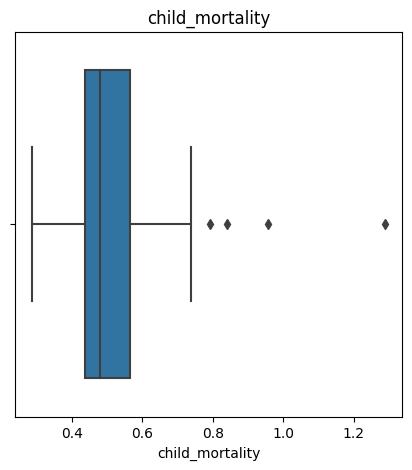

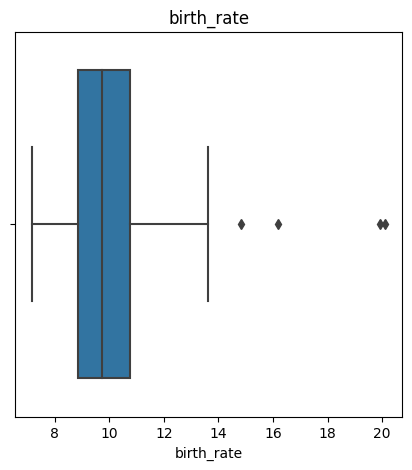

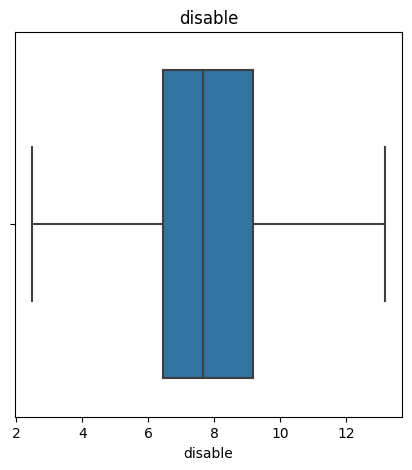

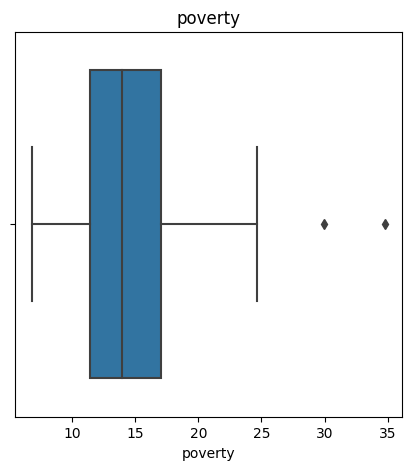

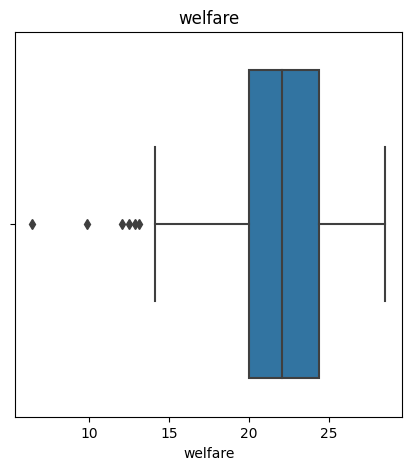

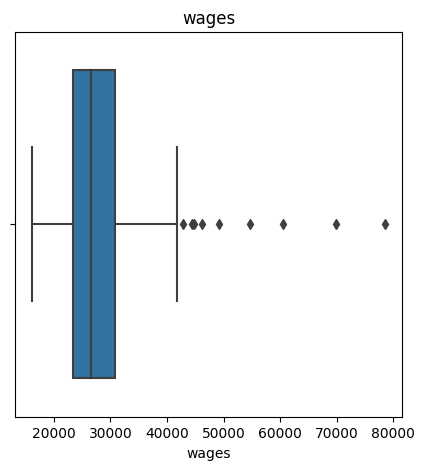

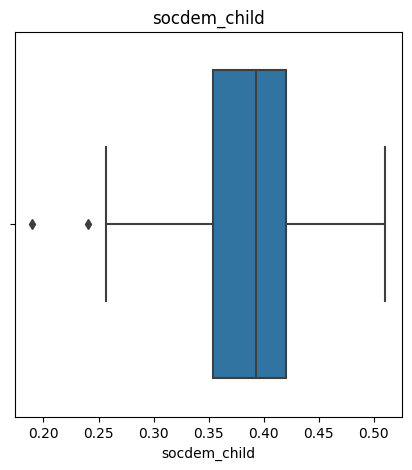

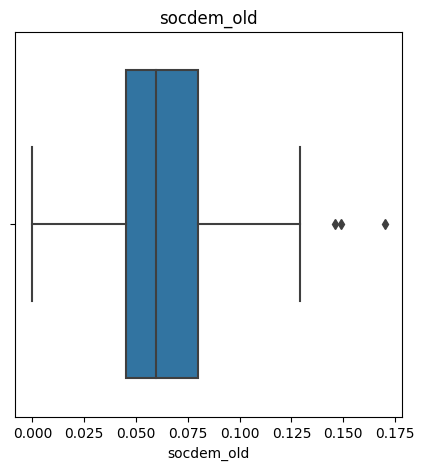

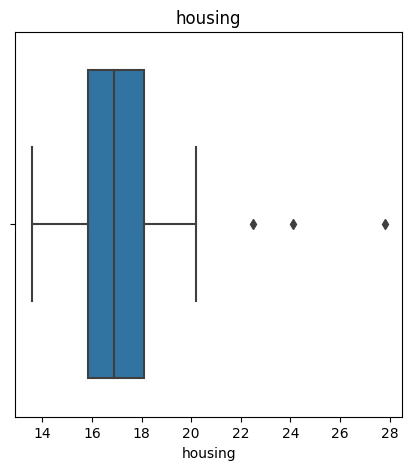

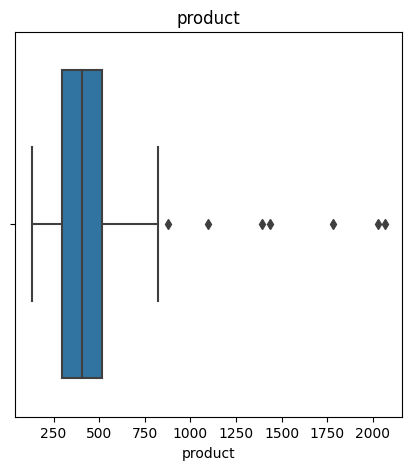

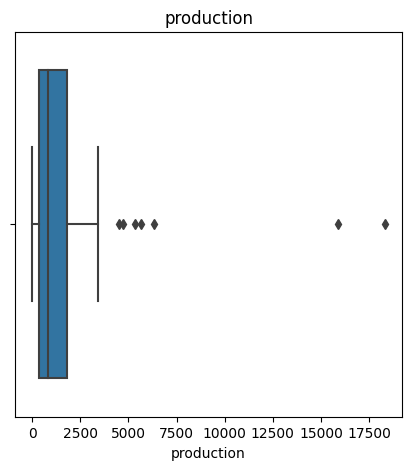

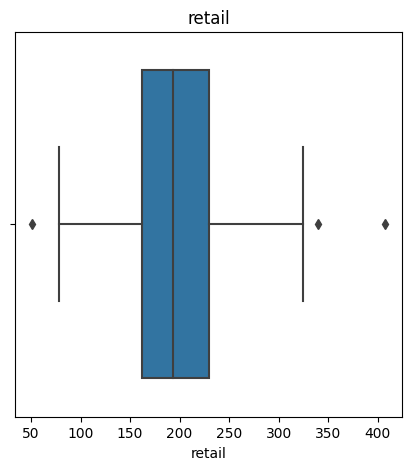

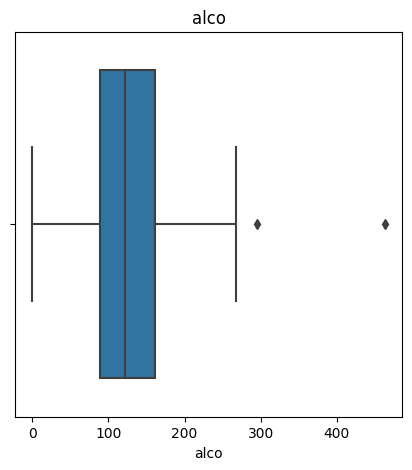

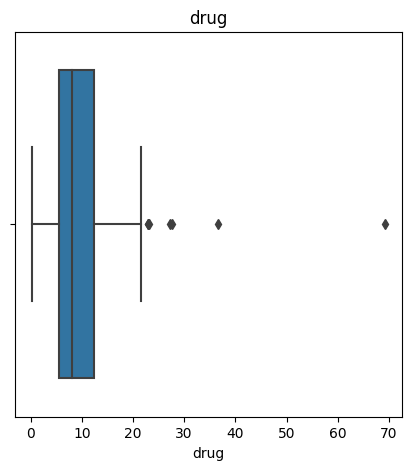

In [99]:
for column in final_df.columns:
    #посмотрим на выбросы по всем признакам
    fig = plt.figure(figsize=(5, 5))
    sns.boxplot(x=final_df[column])
    plt.title(column)
    plt.show()

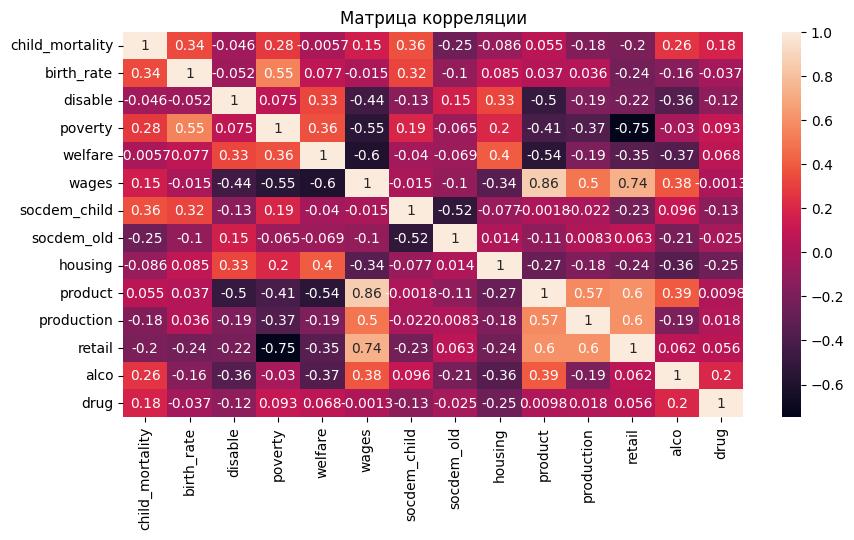

In [100]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(final_df.corr(), annot=True)
plt.title('Матрица корреляции')
plt.show()

Признак product (валовый региональный продукт) довольно сильно коррелирует с признаком wages (реальные доходы), а также wages имеет сильную связь с retail, уберем признак wages из расчетов

In [101]:
X = final_df.copy()
X = X.drop(columns=['wages'])
X.index = range(X.shape[0])
X

,child_mortality,birth_rate,disable,poverty,welfare,socdem_child,socdem_old,housing,product,production,retail,alco,drug
0,0.539849,9.113339,7.547573,17.56,27.82,0.421,0.051,18.0,253.17402,799.482609,156.3514,174.0,17.40
1,0.517494,10.044177,8.306587,16.04,24.74,0.406,0.046,17.3,451.29098,320.552034,233.9414,204.7,21.55
2,0.478808,9.021280,7.561887,13.88,21.82,0.395,0.065,16.9,699.02138,1274.618544,242.7436,120.0,7.30
3,0.600601,10.941735,4.335745,15.56,26.36,0.350,0.052,19.2,497.99036,784.112179,176.8630,48.4,0.45
4,0.441790,8.518860,13.162239,7.68,14.74,0.448,0.129,17.8,578.76506,1795.971572,229.4576,86.5,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.496357,9.938642,6.369715,13.04,22.80,0.442,0.032,16.0,427.01282,3395.338541,164.2124,137.3,23.20
78,0.649222,20.098238,11.065296,19.92,28.48,0.460,0.055,19.2,157.07556,73.590426,122.4336,7.1,0.70
79,0.308668,9.576965,6.410610,17.84,23.52,0.405,0.073,14.2,258.84044,475.307529,136.7514,155.4,1.45
80,1.288245,10.842571,3.273850,8.48,6.48,0.510,0.000,14.1,1780.29736,187.491615,205.9542,462.8,1.00


In [102]:
minmax = MinMaxScaler()
X_scal = minmax.fit_transform(X)

In [103]:
pca = PCA(n_components=0.9)
princ_comp = pca.fit_transform(X_scal)
X_pca = pd.DataFrame(princ_comp)

In [104]:
#попробуем несколько алгоритмов кластеризации с разным количеством кластеров
#в качестве метриц возьмем коэффициент Силуэта и метрику Дэвиса-Болдина
result = {}
for k in range(2, 6):
    y_pred = []
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_pred.append(kmeans.fit_predict(X_pca))
    aglo = AgglomerativeClustering(n_clusters=k)
    y_pred.append(aglo.fit_predict(X_pca))
    gm = GaussianMixture(n_components=k, random_state=42)
    y_pred.append(gm.fit_predict(X_pca))
    result[k] = []
    for i in range(len(y_pred)):
        result[k].append(silhouette_score(X_pca, y_pred[i]))
        result[k].append(davies_bouldin_score(X_pca, y_pred[i]))


In [105]:
result_df = pd.DataFrame(data=result.values(), index=result.keys(), columns=[
    'silhouette_kmeans', 'davies_kmeans', 'silhouette_aglo', 'davies_aglo', 'silhouette_gm', 'davies_gm'])
result_df

,silhouette_kmeans,davies_kmeans,silhouette_aglo,davies_aglo,silhouette_gm,davies_gm
2,0.289913,1.709725,0.388660,1.533139,0.337575,1.724441
3,0.291248,1.402154,0.314240,1.528198,0.194867,1.994946
4,0.237256,1.564065,0.312557,1.212932,0.104130,2.250011
5,0.116950,1.631716,0.289206,1.165459,0.109341,1.834502


<AxesSubplot:>

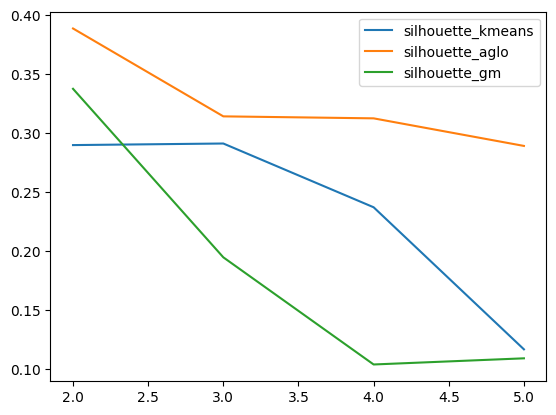

In [106]:
result_df[['silhouette_kmeans', 'silhouette_aglo', 'silhouette_gm']].plot()

<AxesSubplot:>

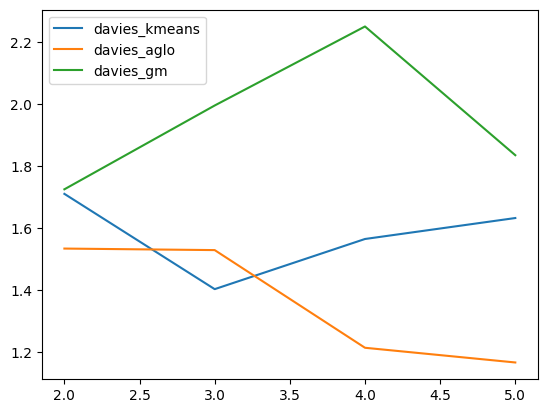

In [107]:
result_df[['davies_kmeans', 'davies_aglo', 'davies_gm']].plot()

In [108]:
#выберем в качестве модели алгоритм kmeans кластеризации с количеством кластеров - 4 (более выражен эффект локтя для коэффициента силуэта)
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred_km = kmeans.fit_predict(X_pca)
final_df['kmeans'] = y_pred_km
cluster_count = final_df['kmeans'].nunique()

In [109]:
X.index = final_df.index
X['kmeans'] = final_df['kmeans']
group_df = X.groupby(by='kmeans').mean()
group_df

,child_mortality,birth_rate,disable,poverty,welfare,socdem_child,socdem_old,housing,product,production,retail,alco,drug
kmeans,,,,,,,,,,,,,
0,0.425335,9.343285,8.148300,9.858000,16.490000,0.337200,0.109600,16.790000,518.163640,2461.012497,236.511140,109.540000,11.405000
1,0.576770,11.369618,4.529388,10.926667,14.063333,0.397500,0.053500,15.583333,1633.476707,6403.525684,282.067333,235.383333,8.916667
2,0.494585,9.375560,7.768094,14.162182,22.706545,0.391764,0.057309,17.152727,426.018477,1297.896383,191.188218,130.230909,10.245455
3,0.649460,13.957980,8.766767,23.714545,24.040000,0.406273,0.070909,18.454545,235.870920,107.616063,130.080036,93.418182,11.859091


In [110]:
group_df = pd.DataFrame(minmax.fit_transform(group_df), columns=group_df.columns)
group_df

,child_mortality,birth_rate,disable,poverty,welfare,socdem_child,socdem_old,housing,product,production,retail,alco,drug
0,0.000000,0.000000,0.854045,0.000000,0.243234,0.000000,1.000000,0.420264,0.201983,0.373798,0.700263,0.113562,0.845675
1,0.675670,0.439104,0.000000,0.077124,0.000000,0.872993,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.308977,0.006994,0.764318,0.310624,0.866343,0.789945,0.067898,0.546596,0.136052,0.189056,0.402061,0.259308,0.451596
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.310322,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [111]:
features = ['birth_rate', 'disable', 'poverty', 'welfare', 'retail', 'product', 'production']
group_df = group_df[features]
fig = go.Figure()
for i in range(cluster_count):
    fig.add_scatterpolar(
        r=group_df.iloc[i].values, 
        theta = features, 
        fill='toself')
fig.show()

Судя по диаграмме:

кластер 1 - очень благоприятный регион

кластер 3 - самый бедный регион

кластер 0 выглядит лучше чем 2

In [112]:
result_dict = {}
for i in range(cluster_count):
    result_dict[i] = final_df[final_df['kmeans'] == i].index.to_list()
    print(result_dict[i])

['Белгородская область', 'Воронежская область', 'Калининградская область', 'Ленинградская область', 'Московская область', 'Новгородская область', 'Республика Адыгея', 'Республика Татарстан', 'Санкт-Петербург', 'Севастополь']
['Магаданская область', 'Москва', 'Республика Саха', 'Сахалинская область', 'Тюменская область', 'Чукотский автономный округ']
['Алтайский край', 'Амурская область', 'Архангельская область', 'Астраханская область', 'Брянская область', 'Владимирская область', 'Волгоградская область', 'Вологодская область', 'Ивановская область', 'Иркутская область', 'Калужская область', 'Камчатский край', 'Кемеровская область', 'Кировская область', 'Костромская область', 'Краснодарский край', 'Красноярский край', 'Курганская область', 'Курская область', 'Липецкая область', 'Мурманская область', 'Нижегородская область', 'Новосибирская область', 'Омская область', 'Оренбургская область', 'Орловская область', 'Пензенская область', 'Пермский край', 'Приморский край', 'Псковская область', 

In [113]:
final_df.groupby(by='kmeans').describe().to_excel('out/group_df.xlsx')

0 - регион-комфорт (данный регион относится к благополучным регионам: довольно высокие доходы населения, высокая покупательская способность, процент людей живущих за чертой бедности не высокий по сравнению с другими регионами. Стоит обратить внимание на количество наркозависимых людей, а также направить помощь людям преклонного возраста)

1 - бизнес-регион (данный регион относится к самым богатым регионам: здесь самые высокие доходы населения, самое большое производство, довольно высокая рождаемость, небольшой процент людей с инвалидностью и самый маленький процент людей, живущих за чертой бедности. Но стоит обратить внимание на людей страдающих алкоголизмом!)

2 - средне-статистический регион (рождаемость не высокая, довольно большой процент людей с инвалидностью и людей живущих за чертой бедности, есть собственное производство, но его явно недостаточно, поскольку доходы населения и розничная торговля не высокие. Стоит также обратить внимание на алко и наркозависимых людей)

3 - бедный регион (данный регион относится к регионам, остро нуждающихся в помощи малообоеспеченным слоям населения: здесь высокая рождаемость, но и довольно высокая смертность детей на 1-м году жизни. Здесь большой процент людей, живущих за чертой бедности. У региона нет большого местного производства, доходы у населения небольшие. Стоит обратить внимание на детские пособия и помощь пенсионерам)

In [114]:
regions_classifier = {} #создаем классификатор, который по названию региона будет содержать информацию о нем

for ind in final_df.index:
    if final_df.loc[ind, 'kmeans'] == 0:
        regions_classifier[ind] = 'Регион-комфорт (данный регион относится к благополучным регионам: довольно высокие доходы населения, высокая покупательская способность, процент людей живущих за чертой бедности не высокий по сравнению с другими регионами. Стоит обратить внимание на количество наркозависимых людей, а также направить помощь людям преклонного возраста)'
    elif final_df.loc[ind, 'kmeans'] == 1:
        regions_classifier[ind] = 'Бизнес-регион (данный регион относится к самым богатым регионам: здесь самые высокие доходы населения, самое большое производство, довольно высокая рождаемость, небольшой процент людей с инвалидностью и самый маленький процент людей, живущих за чертой бедности. Но стоит обратить внимание на людей страдающих алкоголизмом!)'
    elif final_df.loc[ind, 'kmeans'] == 2:
        regions_classifier[ind] = 'Средне-статистический регион (рождаемость не высокая, довольно большой процент людей с инвалидностью и людей живущих за чертой бедности, есть собственное производство, но его явно недостаточно, поскольку доходы населения и розничная торговля не высокие. Стоит также обратить внимание на алко и наркозависимых людей)'
    else:
        regions_classifier[ind] = 'Бедный регион (данный регион относится к регионам, остро нуждающихся в помощи малообоеспеченным слоям населения: здесь высокая рождаемость, но и довольно высокая смертность детей на 1-м году жизни. Здесь большой процент людей, живущих за чертой бедности. У региона нет большого местного производства, доходы у населения небольшие. Стоит обратить внимание на помощь семьям с детьми)'

In [115]:
with open('app/model/regions_classifier.pkl', 'wb') as output:
    pickle.dump(regions_classifier, output)